# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

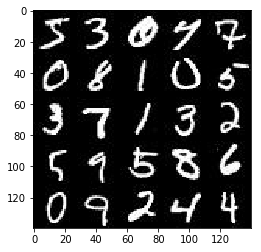

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

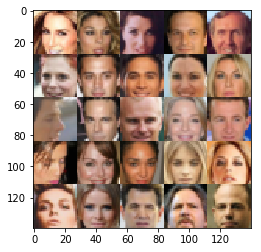

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,) + (image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (inputs_real, inputs_z, learning_rate)

  
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.8):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function   
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        # 7x7x128
        
        # Flattening it!
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        out = tf.nn.dropout(out, keep_prob)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1*alpha)
        # 7x7x256 print("x1:", x1.get_shape().as_list())
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2*alpha)
        # 14x14x128 print("x2:", x2.get_shape().as_list())
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
                
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.1, keep_prob=0.8):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob=keep_prob)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
              print_every=20, show_every=500, alpha=0.1, smooth=0.1, keep_prob=0.8):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha, smooth=smooth, keep_prob=keep_prob)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Normalizing since they are between [-0.5, 0.5]
                batch_images = 2*batch_images
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch: {}/{}\tStep: {}\t".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/20	Step: 20	 Discriminator Loss: 1.4691	 Generator Loss: 5.3325
Epoch: 1/20	Step: 40	 Discriminator Loss: 2.2402	 Generator Loss: 0.2259
Epoch: 1/20	Step: 60	 Discriminator Loss: 2.1768	 Generator Loss: 0.2238
Epoch: 1/20	Step: 80	 Discriminator Loss: 1.6170	 Generator Loss: 0.4271
Epoch: 1/20	Step: 100	 Discriminator Loss: 1.7064	 Generator Loss: 0.3738
Epoch: 1/20	Step: 120	 Discriminator Loss: 1.4612	 Generator Loss: 0.5094
Epoch: 1/20	Step: 140	 Discriminator Loss: 1.3578	 Generator Loss: 1.1369
Epoch: 1/20	Step: 160	 Discriminator Loss: 1.3256	 Generator Loss: 1.1134
Epoch: 1/20	Step: 180	 Discriminator Loss: 1.2966	 Generator Loss: 1.1221
Epoch: 1/20	Step: 200	 Discriminator Loss: 1.3214	 Generator Loss: 1.5033
Epoch: 1/20	Step: 220	 Discriminator Loss: 1.4910	 Generator Loss: 0.4650
Epoch: 1/20	Step: 240	 Discriminator Loss: 1.4677	 Generator Loss: 0.4639
Epoch: 1/20	Step: 260	 Discriminator Loss: 1.4151	 Generator Loss: 0.4828
Epoch: 1/20	Step: 280	 Discriminator Loss:

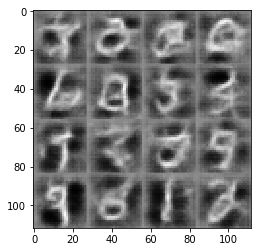

Epoch: 1/20	Step: 480	 Discriminator Loss: 1.3851	 Generator Loss: 0.5268
Epoch: 1/20	Step: 500	 Discriminator Loss: 1.3488	 Generator Loss: 0.5913
Epoch: 1/20	Step: 520	 Discriminator Loss: 1.5034	 Generator Loss: 0.4788
Epoch: 1/20	Step: 540	 Discriminator Loss: 1.1985	 Generator Loss: 1.4353
Epoch: 1/20	Step: 560	 Discriminator Loss: 1.2341	 Generator Loss: 1.1486
Epoch: 1/20	Step: 580	 Discriminator Loss: 1.2506	 Generator Loss: 0.9658
Epoch: 1/20	Step: 600	 Discriminator Loss: 1.2564	 Generator Loss: 1.2420
Epoch: 1/20	Step: 620	 Discriminator Loss: 1.2916	 Generator Loss: 1.1729
Epoch: 1/20	Step: 640	 Discriminator Loss: 1.4195	 Generator Loss: 0.4972
Epoch: 1/20	Step: 660	 Discriminator Loss: 1.4207	 Generator Loss: 0.5135
Epoch: 1/20	Step: 680	 Discriminator Loss: 1.4053	 Generator Loss: 1.6091
Epoch: 1/20	Step: 700	 Discriminator Loss: 1.2526	 Generator Loss: 1.1218
Epoch: 1/20	Step: 720	 Discriminator Loss: 1.2640	 Generator Loss: 0.7717
Epoch: 1/20	Step: 740	 Discriminator L

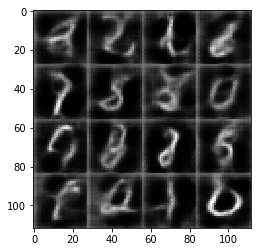

Epoch: 2/20	Step: 940	 Discriminator Loss: 1.2312	 Generator Loss: 0.7410
Epoch: 2/20	Step: 960	 Discriminator Loss: 1.2459	 Generator Loss: 0.7076
Epoch: 2/20	Step: 980	 Discriminator Loss: 1.4920	 Generator Loss: 0.4407
Epoch: 2/20	Step: 1000	 Discriminator Loss: 1.1996	 Generator Loss: 1.6561
Epoch: 2/20	Step: 1020	 Discriminator Loss: 1.2072	 Generator Loss: 0.7458
Epoch: 2/20	Step: 1040	 Discriminator Loss: 1.5638	 Generator Loss: 0.3936
Epoch: 2/20	Step: 1060	 Discriminator Loss: 1.1214	 Generator Loss: 0.8453
Epoch: 2/20	Step: 1080	 Discriminator Loss: 1.2887	 Generator Loss: 1.2816
Epoch: 2/20	Step: 1100	 Discriminator Loss: 1.2055	 Generator Loss: 0.9153
Epoch: 2/20	Step: 1120	 Discriminator Loss: 1.4056	 Generator Loss: 0.5102
Epoch: 2/20	Step: 1140	 Discriminator Loss: 1.3818	 Generator Loss: 0.5127
Epoch: 2/20	Step: 1160	 Discriminator Loss: 1.1849	 Generator Loss: 1.1445
Epoch: 2/20	Step: 1180	 Discriminator Loss: 1.1358	 Generator Loss: 1.0783
Epoch: 2/20	Step: 1200	 Disc

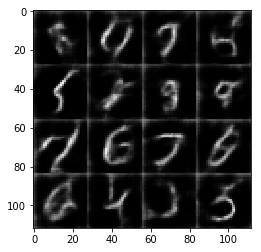

Epoch: 2/20	Step: 1400	 Discriminator Loss: 1.0901	 Generator Loss: 0.8475
Epoch: 2/20	Step: 1420	 Discriminator Loss: 1.1411	 Generator Loss: 1.0580
Epoch: 2/20	Step: 1440	 Discriminator Loss: 1.0860	 Generator Loss: 0.8767
Epoch: 2/20	Step: 1460	 Discriminator Loss: 1.7793	 Generator Loss: 0.3063
Epoch: 2/20	Step: 1480	 Discriminator Loss: 1.4635	 Generator Loss: 0.4704
Epoch: 2/20	Step: 1500	 Discriminator Loss: 1.2076	 Generator Loss: 1.3912
Epoch: 2/20	Step: 1520	 Discriminator Loss: 1.0765	 Generator Loss: 0.9073
Epoch: 2/20	Step: 1540	 Discriminator Loss: 1.0876	 Generator Loss: 1.0389
Epoch: 2/20	Step: 1560	 Discriminator Loss: 1.2910	 Generator Loss: 0.6106
Epoch: 2/20	Step: 1580	 Discriminator Loss: 1.1866	 Generator Loss: 1.2778
Epoch: 2/20	Step: 1600	 Discriminator Loss: 1.0832	 Generator Loss: 1.4688
Epoch: 2/20	Step: 1620	 Discriminator Loss: 1.0858	 Generator Loss: 1.3121
Epoch: 2/20	Step: 1640	 Discriminator Loss: 1.1855	 Generator Loss: 0.7251
Epoch: 2/20	Step: 1660	 D

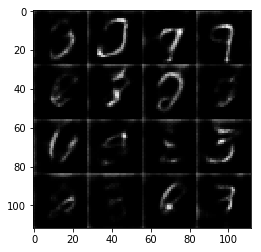

Epoch: 2/20	Step: 1860	 Discriminator Loss: 1.2400	 Generator Loss: 0.6224
Epoch: 3/20	Step: 1880	 Discriminator Loss: 1.3137	 Generator Loss: 0.6049
Epoch: 3/20	Step: 1900	 Discriminator Loss: 1.1014	 Generator Loss: 0.8674
Epoch: 3/20	Step: 1920	 Discriminator Loss: 1.3885	 Generator Loss: 0.5396
Epoch: 3/20	Step: 1940	 Discriminator Loss: 1.5374	 Generator Loss: 0.4388
Epoch: 3/20	Step: 1960	 Discriminator Loss: 1.1545	 Generator Loss: 0.7873
Epoch: 3/20	Step: 1980	 Discriminator Loss: 1.3159	 Generator Loss: 0.6010
Epoch: 3/20	Step: 2000	 Discriminator Loss: 1.1125	 Generator Loss: 0.7976
Epoch: 3/20	Step: 2020	 Discriminator Loss: 1.0300	 Generator Loss: 0.9429
Epoch: 3/20	Step: 2040	 Discriminator Loss: 1.4209	 Generator Loss: 0.4923
Epoch: 3/20	Step: 2060	 Discriminator Loss: 1.0640	 Generator Loss: 1.0163
Epoch: 3/20	Step: 2080	 Discriminator Loss: 0.9865	 Generator Loss: 1.4502
Epoch: 3/20	Step: 2100	 Discriminator Loss: 1.0902	 Generator Loss: 0.8475
Epoch: 3/20	Step: 2120	 D

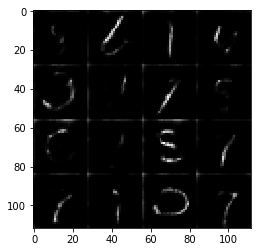

Epoch: 3/20	Step: 2320	 Discriminator Loss: 1.0262	 Generator Loss: 0.8291
Epoch: 3/20	Step: 2340	 Discriminator Loss: 1.4541	 Generator Loss: 0.4458
Epoch: 3/20	Step: 2360	 Discriminator Loss: 1.1999	 Generator Loss: 0.7225
Epoch: 3/20	Step: 2380	 Discriminator Loss: 1.1371	 Generator Loss: 1.0868
Epoch: 3/20	Step: 2400	 Discriminator Loss: 1.0163	 Generator Loss: 0.9466
Epoch: 3/20	Step: 2420	 Discriminator Loss: 1.0711	 Generator Loss: 0.8432
Epoch: 3/20	Step: 2440	 Discriminator Loss: 1.6215	 Generator Loss: 0.4148
Epoch: 3/20	Step: 2460	 Discriminator Loss: 1.0334	 Generator Loss: 1.2487
Epoch: 3/20	Step: 2480	 Discriminator Loss: 1.7443	 Generator Loss: 0.3470
Epoch: 3/20	Step: 2500	 Discriminator Loss: 2.0639	 Generator Loss: 0.2521
Epoch: 3/20	Step: 2520	 Discriminator Loss: 1.0111	 Generator Loss: 0.9178
Epoch: 3/20	Step: 2540	 Discriminator Loss: 1.2433	 Generator Loss: 0.6621
Epoch: 3/20	Step: 2560	 Discriminator Loss: 1.3945	 Generator Loss: 0.5229
Epoch: 3/20	Step: 2580	 D

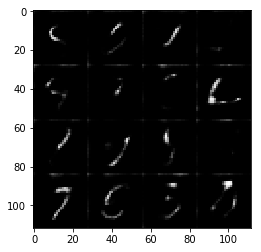

Epoch: 3/20	Step: 2780	 Discriminator Loss: 1.1520	 Generator Loss: 2.0531
Epoch: 3/20	Step: 2800	 Discriminator Loss: 0.8300	 Generator Loss: 1.2574
Epoch: 4/20	Step: 2820	 Discriminator Loss: 1.0339	 Generator Loss: 1.3447
Epoch: 4/20	Step: 2840	 Discriminator Loss: 1.2407	 Generator Loss: 0.6546
Epoch: 4/20	Step: 2860	 Discriminator Loss: 1.1402	 Generator Loss: 1.6943
Epoch: 4/20	Step: 2880	 Discriminator Loss: 0.9545	 Generator Loss: 2.0355
Epoch: 4/20	Step: 2900	 Discriminator Loss: 1.4160	 Generator Loss: 0.5365
Epoch: 4/20	Step: 2920	 Discriminator Loss: 1.1580	 Generator Loss: 0.6946
Epoch: 4/20	Step: 2940	 Discriminator Loss: 0.9177	 Generator Loss: 1.0353
Epoch: 4/20	Step: 2960	 Discriminator Loss: 0.9953	 Generator Loss: 1.6189
Epoch: 4/20	Step: 2980	 Discriminator Loss: 1.4721	 Generator Loss: 0.4677
Epoch: 4/20	Step: 3000	 Discriminator Loss: 1.7389	 Generator Loss: 0.3316
Epoch: 4/20	Step: 3020	 Discriminator Loss: 1.2143	 Generator Loss: 0.6502
Epoch: 4/20	Step: 3040	 D

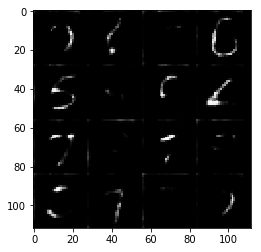

Epoch: 4/20	Step: 3240	 Discriminator Loss: 1.4861	 Generator Loss: 0.4631
Epoch: 4/20	Step: 3260	 Discriminator Loss: 1.0949	 Generator Loss: 0.7951
Epoch: 4/20	Step: 3280	 Discriminator Loss: 0.9638	 Generator Loss: 1.1197
Epoch: 4/20	Step: 3300	 Discriminator Loss: 1.5093	 Generator Loss: 0.4633
Epoch: 4/20	Step: 3320	 Discriminator Loss: 1.0624	 Generator Loss: 0.9657
Epoch: 4/20	Step: 3340	 Discriminator Loss: 1.4392	 Generator Loss: 0.5504
Epoch: 4/20	Step: 3360	 Discriminator Loss: 0.9832	 Generator Loss: 0.9435
Epoch: 4/20	Step: 3380	 Discriminator Loss: 1.2356	 Generator Loss: 1.9402
Epoch: 4/20	Step: 3400	 Discriminator Loss: 2.1781	 Generator Loss: 0.2234
Epoch: 4/20	Step: 3420	 Discriminator Loss: 1.2632	 Generator Loss: 0.6795
Epoch: 4/20	Step: 3440	 Discriminator Loss: 0.8361	 Generator Loss: 1.3029
Epoch: 4/20	Step: 3460	 Discriminator Loss: 0.8077	 Generator Loss: 1.1646
Epoch: 4/20	Step: 3480	 Discriminator Loss: 1.0487	 Generator Loss: 1.0266
Epoch: 4/20	Step: 3500	 D

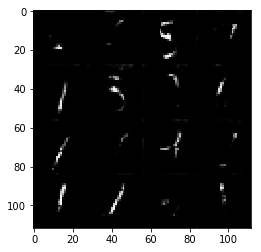

Epoch: 4/20	Step: 3700	 Discriminator Loss: 0.9216	 Generator Loss: 1.0017
Epoch: 4/20	Step: 3720	 Discriminator Loss: 0.8222	 Generator Loss: 1.4393
Epoch: 4/20	Step: 3740	 Discriminator Loss: 1.2702	 Generator Loss: 0.6320
Epoch: 5/20	Step: 3760	 Discriminator Loss: 0.8214	 Generator Loss: 1.3105
Epoch: 5/20	Step: 3780	 Discriminator Loss: 0.9958	 Generator Loss: 0.8891
Epoch: 5/20	Step: 3800	 Discriminator Loss: 1.1035	 Generator Loss: 2.4524
Epoch: 5/20	Step: 3820	 Discriminator Loss: 1.0580	 Generator Loss: 1.5447
Epoch: 5/20	Step: 3840	 Discriminator Loss: 1.0222	 Generator Loss: 1.6833
Epoch: 5/20	Step: 3860	 Discriminator Loss: 0.9975	 Generator Loss: 0.9030
Epoch: 5/20	Step: 3880	 Discriminator Loss: 0.8691	 Generator Loss: 1.2631
Epoch: 5/20	Step: 3900	 Discriminator Loss: 1.4126	 Generator Loss: 3.1306
Epoch: 5/20	Step: 3920	 Discriminator Loss: 0.7838	 Generator Loss: 1.8634
Epoch: 5/20	Step: 3940	 Discriminator Loss: 0.7759	 Generator Loss: 1.5148
Epoch: 5/20	Step: 3960	 D

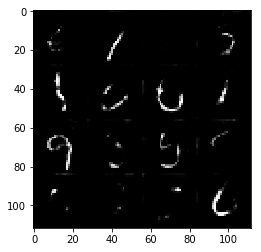

Epoch: 5/20	Step: 4160	 Discriminator Loss: 1.1984	 Generator Loss: 1.8461
Epoch: 5/20	Step: 4180	 Discriminator Loss: 0.8731	 Generator Loss: 1.4707
Epoch: 5/20	Step: 4200	 Discriminator Loss: 0.8087	 Generator Loss: 1.2357
Epoch: 5/20	Step: 4220	 Discriminator Loss: 0.9516	 Generator Loss: 1.1177
Epoch: 5/20	Step: 4240	 Discriminator Loss: 0.9035	 Generator Loss: 1.0294
Epoch: 5/20	Step: 4260	 Discriminator Loss: 0.9872	 Generator Loss: 1.4838
Epoch: 5/20	Step: 4280	 Discriminator Loss: 0.8343	 Generator Loss: 1.2040
Epoch: 5/20	Step: 4300	 Discriminator Loss: 0.7118	 Generator Loss: 1.5226
Epoch: 5/20	Step: 4320	 Discriminator Loss: 1.2872	 Generator Loss: 0.6989
Epoch: 5/20	Step: 4340	 Discriminator Loss: 0.9000	 Generator Loss: 1.0674
Epoch: 5/20	Step: 4360	 Discriminator Loss: 0.6055	 Generator Loss: 2.3221
Epoch: 5/20	Step: 4380	 Discriminator Loss: 1.6918	 Generator Loss: 0.4607
Epoch: 5/20	Step: 4400	 Discriminator Loss: 1.7702	 Generator Loss: 0.3522
Epoch: 5/20	Step: 4420	 D

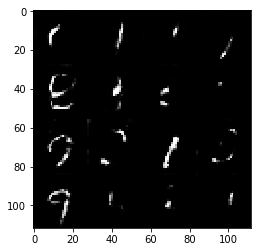

Epoch: 5/20	Step: 4620	 Discriminator Loss: 1.0900	 Generator Loss: 1.7121
Epoch: 5/20	Step: 4640	 Discriminator Loss: 0.7812	 Generator Loss: 1.9234
Epoch: 5/20	Step: 4660	 Discriminator Loss: 1.1221	 Generator Loss: 0.8284
Epoch: 5/20	Step: 4680	 Discriminator Loss: 0.9834	 Generator Loss: 0.9054
Epoch: 6/20	Step: 4700	 Discriminator Loss: 0.9884	 Generator Loss: 1.4844
Epoch: 6/20	Step: 4720	 Discriminator Loss: 1.1016	 Generator Loss: 2.0338
Epoch: 6/20	Step: 4740	 Discriminator Loss: 0.8870	 Generator Loss: 1.2154
Epoch: 6/20	Step: 4760	 Discriminator Loss: 1.2311	 Generator Loss: 0.6806
Epoch: 6/20	Step: 4780	 Discriminator Loss: 0.6586	 Generator Loss: 1.6313
Epoch: 6/20	Step: 4800	 Discriminator Loss: 1.9319	 Generator Loss: 0.3134
Epoch: 6/20	Step: 4820	 Discriminator Loss: 1.2506	 Generator Loss: 0.6205
Epoch: 6/20	Step: 4840	 Discriminator Loss: 0.7065	 Generator Loss: 1.4577
Epoch: 6/20	Step: 4860	 Discriminator Loss: 1.6967	 Generator Loss: 0.5341
Epoch: 6/20	Step: 4880	 D

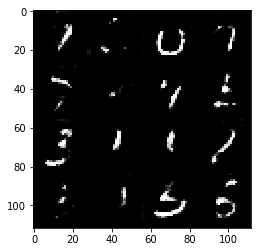

Epoch: 6/20	Step: 5080	 Discriminator Loss: 1.0660	 Generator Loss: 0.8557
Epoch: 6/20	Step: 5100	 Discriminator Loss: 1.1400	 Generator Loss: 1.0022
Epoch: 6/20	Step: 5120	 Discriminator Loss: 0.9116	 Generator Loss: 1.2986
Epoch: 6/20	Step: 5140	 Discriminator Loss: 0.9435	 Generator Loss: 1.0425
Epoch: 6/20	Step: 5160	 Discriminator Loss: 1.0760	 Generator Loss: 0.8131
Epoch: 6/20	Step: 5180	 Discriminator Loss: 0.6062	 Generator Loss: 1.8310
Epoch: 6/20	Step: 5200	 Discriminator Loss: 1.3738	 Generator Loss: 0.6067
Epoch: 6/20	Step: 5220	 Discriminator Loss: 0.6020	 Generator Loss: 1.8960
Epoch: 6/20	Step: 5240	 Discriminator Loss: 0.6206	 Generator Loss: 1.7559
Epoch: 6/20	Step: 5260	 Discriminator Loss: 0.9128	 Generator Loss: 1.7253
Epoch: 6/20	Step: 5280	 Discriminator Loss: 0.8575	 Generator Loss: 1.1480
Epoch: 6/20	Step: 5300	 Discriminator Loss: 0.7409	 Generator Loss: 1.4388
Epoch: 6/20	Step: 5320	 Discriminator Loss: 0.8480	 Generator Loss: 1.2931
Epoch: 6/20	Step: 5340	 D

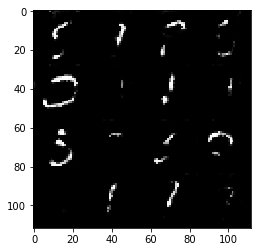

Epoch: 6/20	Step: 5540	 Discriminator Loss: 0.8629	 Generator Loss: 1.1400
Epoch: 6/20	Step: 5560	 Discriminator Loss: 1.0058	 Generator Loss: 1.1147
Epoch: 6/20	Step: 5580	 Discriminator Loss: 0.7802	 Generator Loss: 1.4553
Epoch: 6/20	Step: 5600	 Discriminator Loss: 1.8114	 Generator Loss: 3.3142
Epoch: 6/20	Step: 5620	 Discriminator Loss: 0.8044	 Generator Loss: 1.4302
Epoch: 7/20	Step: 5640	 Discriminator Loss: 0.9013	 Generator Loss: 1.1442
Epoch: 7/20	Step: 5660	 Discriminator Loss: 0.6910	 Generator Loss: 1.6160
Epoch: 7/20	Step: 5680	 Discriminator Loss: 1.2020	 Generator Loss: 0.7217
Epoch: 7/20	Step: 5700	 Discriminator Loss: 0.7155	 Generator Loss: 1.5487
Epoch: 7/20	Step: 5720	 Discriminator Loss: 0.8108	 Generator Loss: 1.2484
Epoch: 7/20	Step: 5740	 Discriminator Loss: 1.2106	 Generator Loss: 0.8308
Epoch: 7/20	Step: 5760	 Discriminator Loss: 1.8172	 Generator Loss: 0.3566
Epoch: 7/20	Step: 5780	 Discriminator Loss: 0.7958	 Generator Loss: 1.2068
Epoch: 7/20	Step: 5800	 D

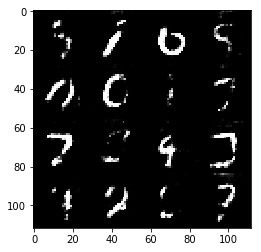

Epoch: 7/20	Step: 6000	 Discriminator Loss: 0.5219	 Generator Loss: 2.5843
Epoch: 7/20	Step: 6020	 Discriminator Loss: 0.6587	 Generator Loss: 1.8084
Epoch: 7/20	Step: 6040	 Discriminator Loss: 0.7604	 Generator Loss: 1.4323
Epoch: 7/20	Step: 6060	 Discriminator Loss: 0.7630	 Generator Loss: 1.3187
Epoch: 7/20	Step: 6080	 Discriminator Loss: 1.0168	 Generator Loss: 0.9964
Epoch: 7/20	Step: 6100	 Discriminator Loss: 0.6249	 Generator Loss: 1.7843
Epoch: 7/20	Step: 6120	 Discriminator Loss: 0.7501	 Generator Loss: 1.8800
Epoch: 7/20	Step: 6140	 Discriminator Loss: 0.6150	 Generator Loss: 2.4679
Epoch: 7/20	Step: 6160	 Discriminator Loss: 0.7064	 Generator Loss: 1.6001
Epoch: 7/20	Step: 6180	 Discriminator Loss: 0.9311	 Generator Loss: 2.9738
Epoch: 7/20	Step: 6200	 Discriminator Loss: 1.0692	 Generator Loss: 0.9190
Epoch: 7/20	Step: 6220	 Discriminator Loss: 0.6944	 Generator Loss: 1.6377
Epoch: 7/20	Step: 6240	 Discriminator Loss: 0.6850	 Generator Loss: 2.3458
Epoch: 7/20	Step: 6260	 D

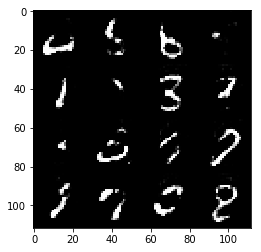

Epoch: 7/20	Step: 6460	 Discriminator Loss: 0.6170	 Generator Loss: 1.7875
Epoch: 7/20	Step: 6480	 Discriminator Loss: 3.1419	 Generator Loss: 0.1549
Epoch: 7/20	Step: 6500	 Discriminator Loss: 0.7672	 Generator Loss: 1.4248
Epoch: 7/20	Step: 6520	 Discriminator Loss: 0.8344	 Generator Loss: 1.3808
Epoch: 7/20	Step: 6540	 Discriminator Loss: 0.9017	 Generator Loss: 1.3806
Epoch: 8/20	Step: 6560	 Discriminator Loss: 1.1581	 Generator Loss: 0.7483
Epoch: 8/20	Step: 6580	 Discriminator Loss: 1.2978	 Generator Loss: 0.6570
Epoch: 8/20	Step: 6600	 Discriminator Loss: 0.7711	 Generator Loss: 1.6391
Epoch: 8/20	Step: 6620	 Discriminator Loss: 1.2008	 Generator Loss: 0.6985
Epoch: 8/20	Step: 6640	 Discriminator Loss: 0.9024	 Generator Loss: 1.1445
Epoch: 8/20	Step: 6660	 Discriminator Loss: 0.8246	 Generator Loss: 2.3913
Epoch: 8/20	Step: 6680	 Discriminator Loss: 1.4738	 Generator Loss: 0.5047
Epoch: 8/20	Step: 6700	 Discriminator Loss: 1.3665	 Generator Loss: 2.4775
Epoch: 8/20	Step: 6720	 D

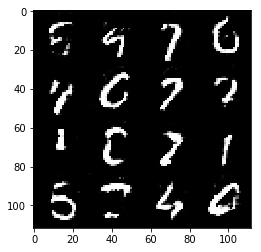

Epoch: 8/20	Step: 6920	 Discriminator Loss: 0.5504	 Generator Loss: 2.0851
Epoch: 8/20	Step: 6940	 Discriminator Loss: 0.7358	 Generator Loss: 1.6107
Epoch: 8/20	Step: 6960	 Discriminator Loss: 0.9264	 Generator Loss: 1.2380
Epoch: 8/20	Step: 6980	 Discriminator Loss: 0.7143	 Generator Loss: 1.4665
Epoch: 8/20	Step: 7000	 Discriminator Loss: 0.6821	 Generator Loss: 1.5538
Epoch: 8/20	Step: 7020	 Discriminator Loss: 0.6754	 Generator Loss: 1.5670
Epoch: 8/20	Step: 7040	 Discriminator Loss: 0.7025	 Generator Loss: 1.9722
Epoch: 8/20	Step: 7060	 Discriminator Loss: 0.7143	 Generator Loss: 1.6177
Epoch: 8/20	Step: 7080	 Discriminator Loss: 1.6270	 Generator Loss: 0.4434
Epoch: 8/20	Step: 7100	 Discriminator Loss: 0.6733	 Generator Loss: 1.6673
Epoch: 8/20	Step: 7120	 Discriminator Loss: 0.7028	 Generator Loss: 1.6403
Epoch: 8/20	Step: 7140	 Discriminator Loss: 0.7460	 Generator Loss: 1.3234
Epoch: 8/20	Step: 7160	 Discriminator Loss: 0.5980	 Generator Loss: 1.8320
Epoch: 8/20	Step: 7180	 D

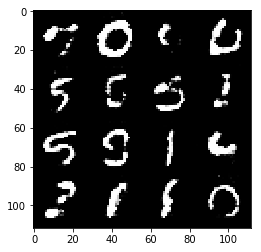

Epoch: 8/20	Step: 7380	 Discriminator Loss: 0.9180	 Generator Loss: 1.2088
Epoch: 8/20	Step: 7400	 Discriminator Loss: 1.1666	 Generator Loss: 0.8099
Epoch: 8/20	Step: 7420	 Discriminator Loss: 0.6015	 Generator Loss: 3.1442
Epoch: 8/20	Step: 7440	 Discriminator Loss: 0.6930	 Generator Loss: 2.4733
Epoch: 8/20	Step: 7460	 Discriminator Loss: 1.0353	 Generator Loss: 0.9971
Epoch: 8/20	Step: 7480	 Discriminator Loss: 0.6951	 Generator Loss: 1.5152
Epoch: 9/20	Step: 7500	 Discriminator Loss: 1.3837	 Generator Loss: 0.6372
Epoch: 9/20	Step: 7520	 Discriminator Loss: 0.8332	 Generator Loss: 1.2894
Epoch: 9/20	Step: 7540	 Discriminator Loss: 0.8324	 Generator Loss: 1.3397
Epoch: 9/20	Step: 7560	 Discriminator Loss: 1.0816	 Generator Loss: 0.8513
Epoch: 9/20	Step: 7580	 Discriminator Loss: 0.6681	 Generator Loss: 1.6158
Epoch: 9/20	Step: 7600	 Discriminator Loss: 0.9328	 Generator Loss: 1.0472
Epoch: 9/20	Step: 7620	 Discriminator Loss: 0.8421	 Generator Loss: 1.2484
Epoch: 9/20	Step: 7640	 D

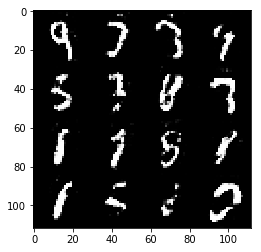

Epoch: 9/20	Step: 7840	 Discriminator Loss: 0.9555	 Generator Loss: 0.9919
Epoch: 9/20	Step: 7860	 Discriminator Loss: 1.0316	 Generator Loss: 0.9786
Epoch: 9/20	Step: 7880	 Discriminator Loss: 0.8296	 Generator Loss: 1.2408
Epoch: 9/20	Step: 7900	 Discriminator Loss: 0.7077	 Generator Loss: 1.5366
Epoch: 9/20	Step: 7920	 Discriminator Loss: 1.2355	 Generator Loss: 0.7554
Epoch: 9/20	Step: 7940	 Discriminator Loss: 0.6677	 Generator Loss: 1.9628
Epoch: 9/20	Step: 7960	 Discriminator Loss: 0.8354	 Generator Loss: 1.1819
Epoch: 9/20	Step: 7980	 Discriminator Loss: 0.8732	 Generator Loss: 1.2091
Epoch: 9/20	Step: 8000	 Discriminator Loss: 0.7663	 Generator Loss: 1.3529
Epoch: 9/20	Step: 8020	 Discriminator Loss: 0.8713	 Generator Loss: 1.1587
Epoch: 9/20	Step: 8040	 Discriminator Loss: 0.7843	 Generator Loss: 1.3072
Epoch: 9/20	Step: 8060	 Discriminator Loss: 1.5483	 Generator Loss: 0.5458
Epoch: 9/20	Step: 8080	 Discriminator Loss: 0.6480	 Generator Loss: 1.8428
Epoch: 9/20	Step: 8100	 D

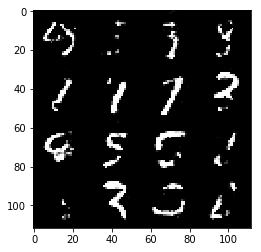

Epoch: 9/20	Step: 8300	 Discriminator Loss: 1.0329	 Generator Loss: 1.0627
Epoch: 9/20	Step: 8320	 Discriminator Loss: 0.9193	 Generator Loss: 1.1151
Epoch: 9/20	Step: 8340	 Discriminator Loss: 0.6962	 Generator Loss: 2.1085
Epoch: 9/20	Step: 8360	 Discriminator Loss: 0.8829	 Generator Loss: 1.1152
Epoch: 9/20	Step: 8380	 Discriminator Loss: 1.5093	 Generator Loss: 0.5810
Epoch: 9/20	Step: 8400	 Discriminator Loss: 0.9068	 Generator Loss: 1.1826
Epoch: 9/20	Step: 8420	 Discriminator Loss: 0.6657	 Generator Loss: 1.8222
Epoch: 10/20	Step: 8440	 Discriminator Loss: 1.0561	 Generator Loss: 2.4816
Epoch: 10/20	Step: 8460	 Discriminator Loss: 0.8124	 Generator Loss: 1.3040
Epoch: 10/20	Step: 8480	 Discriminator Loss: 0.8673	 Generator Loss: 1.1712
Epoch: 10/20	Step: 8500	 Discriminator Loss: 0.6319	 Generator Loss: 1.8975
Epoch: 10/20	Step: 8520	 Discriminator Loss: 1.5244	 Generator Loss: 0.5177
Epoch: 10/20	Step: 8540	 Discriminator Loss: 0.6867	 Generator Loss: 1.6054
Epoch: 10/20	Step: 

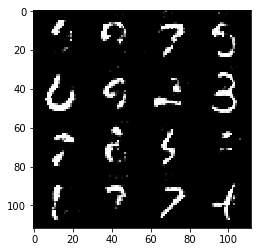

Epoch: 10/20	Step: 8760	 Discriminator Loss: 0.6365	 Generator Loss: 2.1920
Epoch: 10/20	Step: 8780	 Discriminator Loss: 1.0451	 Generator Loss: 0.9722
Epoch: 10/20	Step: 8800	 Discriminator Loss: 0.6387	 Generator Loss: 1.7892
Epoch: 10/20	Step: 8820	 Discriminator Loss: 0.7525	 Generator Loss: 1.3582
Epoch: 10/20	Step: 8840	 Discriminator Loss: 0.8461	 Generator Loss: 2.7541
Epoch: 10/20	Step: 8860	 Discriminator Loss: 0.8375	 Generator Loss: 1.5571
Epoch: 10/20	Step: 8880	 Discriminator Loss: 0.9984	 Generator Loss: 1.0707
Epoch: 10/20	Step: 8900	 Discriminator Loss: 0.8045	 Generator Loss: 1.3040
Epoch: 10/20	Step: 8920	 Discriminator Loss: 0.5120	 Generator Loss: 2.3006
Epoch: 10/20	Step: 8940	 Discriminator Loss: 0.8224	 Generator Loss: 1.3632
Epoch: 10/20	Step: 8960	 Discriminator Loss: 0.6938	 Generator Loss: 1.5998
Epoch: 10/20	Step: 8980	 Discriminator Loss: 0.6754	 Generator Loss: 1.5915
Epoch: 10/20	Step: 9000	 Discriminator Loss: 0.8105	 Generator Loss: 1.4339
Epoch: 10/20

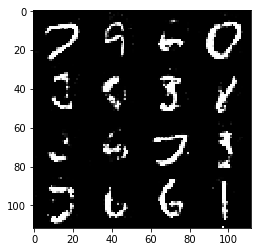

Epoch: 10/20	Step: 9220	 Discriminator Loss: 0.9498	 Generator Loss: 2.6644
Epoch: 10/20	Step: 9240	 Discriminator Loss: 1.2613	 Generator Loss: 0.7092
Epoch: 10/20	Step: 9260	 Discriminator Loss: 0.5745	 Generator Loss: 2.3227
Epoch: 10/20	Step: 9280	 Discriminator Loss: 0.5393	 Generator Loss: 2.3523
Epoch: 10/20	Step: 9300	 Discriminator Loss: 0.6242	 Generator Loss: 2.4016
Epoch: 10/20	Step: 9320	 Discriminator Loss: 0.7239	 Generator Loss: 1.4918
Epoch: 10/20	Step: 9340	 Discriminator Loss: 0.8025	 Generator Loss: 1.2623
Epoch: 10/20	Step: 9360	 Discriminator Loss: 0.5903	 Generator Loss: 2.0023
Epoch: 11/20	Step: 9380	 Discriminator Loss: 1.9479	 Generator Loss: 0.4232
Epoch: 11/20	Step: 9400	 Discriminator Loss: 1.1688	 Generator Loss: 0.7779
Epoch: 11/20	Step: 9420	 Discriminator Loss: 0.7263	 Generator Loss: 1.5540
Epoch: 11/20	Step: 9440	 Discriminator Loss: 0.6466	 Generator Loss: 2.3898
Epoch: 11/20	Step: 9460	 Discriminator Loss: 0.7454	 Generator Loss: 1.6690
Epoch: 11/20

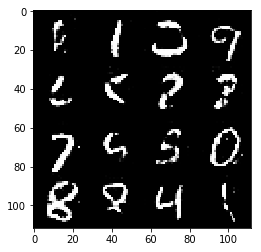

Epoch: 11/20	Step: 9680	 Discriminator Loss: 1.0433	 Generator Loss: 0.9753
Epoch: 11/20	Step: 9700	 Discriminator Loss: 0.7882	 Generator Loss: 1.2537
Epoch: 11/20	Step: 9720	 Discriminator Loss: 0.9431	 Generator Loss: 1.1261
Epoch: 11/20	Step: 9740	 Discriminator Loss: 1.2330	 Generator Loss: 0.7092
Epoch: 11/20	Step: 9760	 Discriminator Loss: 0.6357	 Generator Loss: 2.0555
Epoch: 11/20	Step: 9780	 Discriminator Loss: 0.5468	 Generator Loss: 2.1202
Epoch: 11/20	Step: 9800	 Discriminator Loss: 0.6490	 Generator Loss: 1.7374
Epoch: 11/20	Step: 9820	 Discriminator Loss: 0.7289	 Generator Loss: 1.6390
Epoch: 11/20	Step: 9840	 Discriminator Loss: 0.9901	 Generator Loss: 1.6954
Epoch: 11/20	Step: 9860	 Discriminator Loss: 0.8388	 Generator Loss: 1.5735
Epoch: 11/20	Step: 9880	 Discriminator Loss: 0.7628	 Generator Loss: 1.7177
Epoch: 11/20	Step: 9900	 Discriminator Loss: 0.8522	 Generator Loss: 1.4653
Epoch: 11/20	Step: 9920	 Discriminator Loss: 0.7156	 Generator Loss: 1.6579
Epoch: 11/20

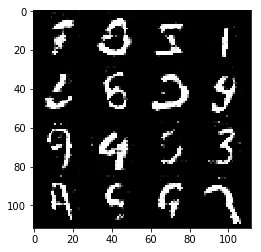

Epoch: 11/20	Step: 10140	 Discriminator Loss: 0.4984	 Generator Loss: 2.4781
Epoch: 11/20	Step: 10160	 Discriminator Loss: 1.4370	 Generator Loss: 0.6011
Epoch: 11/20	Step: 10180	 Discriminator Loss: 0.5618	 Generator Loss: 2.1948
Epoch: 11/20	Step: 10200	 Discriminator Loss: 0.5762	 Generator Loss: 1.9936
Epoch: 11/20	Step: 10220	 Discriminator Loss: 0.7569	 Generator Loss: 1.4175
Epoch: 11/20	Step: 10240	 Discriminator Loss: 0.9084	 Generator Loss: 2.2469
Epoch: 11/20	Step: 10260	 Discriminator Loss: 2.6009	 Generator Loss: 0.3929
Epoch: 11/20	Step: 10280	 Discriminator Loss: 0.6894	 Generator Loss: 1.6340
Epoch: 11/20	Step: 10300	 Discriminator Loss: 1.0216	 Generator Loss: 1.0271
Epoch: 12/20	Step: 10320	 Discriminator Loss: 0.8786	 Generator Loss: 1.3041
Epoch: 12/20	Step: 10340	 Discriminator Loss: 0.8701	 Generator Loss: 1.1970
Epoch: 12/20	Step: 10360	 Discriminator Loss: 1.1745	 Generator Loss: 0.9146
Epoch: 12/20	Step: 10380	 Discriminator Loss: 1.0450	 Generator Loss: 1.0656

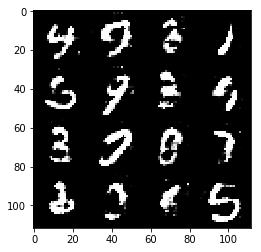

Epoch: 12/20	Step: 10600	 Discriminator Loss: 1.0994	 Generator Loss: 0.9084
Epoch: 12/20	Step: 10620	 Discriminator Loss: 1.2938	 Generator Loss: 3.1849
Epoch: 12/20	Step: 10640	 Discriminator Loss: 1.0540	 Generator Loss: 1.0116
Epoch: 12/20	Step: 10660	 Discriminator Loss: 0.6073	 Generator Loss: 1.9032
Epoch: 12/20	Step: 10680	 Discriminator Loss: 1.5548	 Generator Loss: 4.1028
Epoch: 12/20	Step: 10700	 Discriminator Loss: 0.7644	 Generator Loss: 1.5435
Epoch: 12/20	Step: 10720	 Discriminator Loss: 1.3284	 Generator Loss: 0.6965
Epoch: 12/20	Step: 10740	 Discriminator Loss: 0.7783	 Generator Loss: 1.6041
Epoch: 12/20	Step: 10760	 Discriminator Loss: 0.5943	 Generator Loss: 1.9979
Epoch: 12/20	Step: 10780	 Discriminator Loss: 2.8097	 Generator Loss: 0.2281
Epoch: 12/20	Step: 10800	 Discriminator Loss: 0.7778	 Generator Loss: 1.3473
Epoch: 12/20	Step: 10820	 Discriminator Loss: 0.6702	 Generator Loss: 1.8534
Epoch: 12/20	Step: 10840	 Discriminator Loss: 0.6491	 Generator Loss: 1.6935

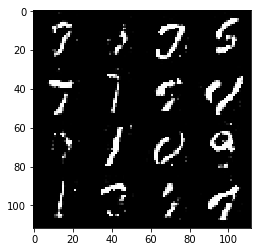

Epoch: 12/20	Step: 11060	 Discriminator Loss: 0.6600	 Generator Loss: 1.8030
Epoch: 12/20	Step: 11080	 Discriminator Loss: 1.3249	 Generator Loss: 0.8803
Epoch: 12/20	Step: 11100	 Discriminator Loss: 0.7801	 Generator Loss: 1.6722
Epoch: 12/20	Step: 11120	 Discriminator Loss: 0.5551	 Generator Loss: 3.0585
Epoch: 12/20	Step: 11140	 Discriminator Loss: 0.4570	 Generator Loss: 2.7290
Epoch: 12/20	Step: 11160	 Discriminator Loss: 1.0045	 Generator Loss: 1.1006
Epoch: 12/20	Step: 11180	 Discriminator Loss: 1.2103	 Generator Loss: 0.7362
Epoch: 12/20	Step: 11200	 Discriminator Loss: 1.1285	 Generator Loss: 0.9379
Epoch: 12/20	Step: 11220	 Discriminator Loss: 0.8685	 Generator Loss: 1.1939
Epoch: 12/20	Step: 11240	 Discriminator Loss: 1.1358	 Generator Loss: 0.8347
Epoch: 13/20	Step: 11260	 Discriminator Loss: 0.6137	 Generator Loss: 2.0503
Epoch: 13/20	Step: 11280	 Discriminator Loss: 0.8072	 Generator Loss: 1.8685
Epoch: 13/20	Step: 11300	 Discriminator Loss: 1.1831	 Generator Loss: 0.8636

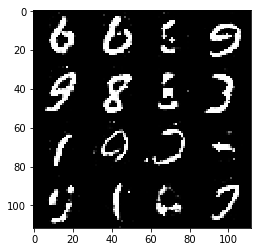

Epoch: 13/20	Step: 11520	 Discriminator Loss: 1.2864	 Generator Loss: 0.9059
Epoch: 13/20	Step: 11540	 Discriminator Loss: 0.5903	 Generator Loss: 2.0350
Epoch: 13/20	Step: 11560	 Discriminator Loss: 1.1478	 Generator Loss: 0.8982
Epoch: 13/20	Step: 11580	 Discriminator Loss: 2.1902	 Generator Loss: 3.1499
Epoch: 13/20	Step: 11600	 Discriminator Loss: 0.8873	 Generator Loss: 2.0169
Epoch: 13/20	Step: 11620	 Discriminator Loss: 0.6358	 Generator Loss: 2.2886
Epoch: 13/20	Step: 11640	 Discriminator Loss: 1.0516	 Generator Loss: 0.9578
Epoch: 13/20	Step: 11660	 Discriminator Loss: 0.8977	 Generator Loss: 1.2319
Epoch: 13/20	Step: 11680	 Discriminator Loss: 0.8587	 Generator Loss: 1.1581
Epoch: 13/20	Step: 11700	 Discriminator Loss: 0.7849	 Generator Loss: 1.4095
Epoch: 13/20	Step: 11720	 Discriminator Loss: 0.7721	 Generator Loss: 1.5466
Epoch: 13/20	Step: 11740	 Discriminator Loss: 1.4340	 Generator Loss: 0.6237
Epoch: 13/20	Step: 11760	 Discriminator Loss: 0.6994	 Generator Loss: 2.5038

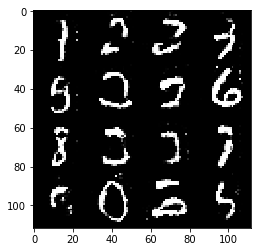

Epoch: 13/20	Step: 11980	 Discriminator Loss: 0.8091	 Generator Loss: 1.4396
Epoch: 13/20	Step: 12000	 Discriminator Loss: 0.7853	 Generator Loss: 2.3609
Epoch: 13/20	Step: 12020	 Discriminator Loss: 0.8566	 Generator Loss: 1.2024
Epoch: 13/20	Step: 12040	 Discriminator Loss: 0.8971	 Generator Loss: 1.0816
Epoch: 13/20	Step: 12060	 Discriminator Loss: 0.7764	 Generator Loss: 1.3741
Epoch: 13/20	Step: 12080	 Discriminator Loss: 0.9180	 Generator Loss: 1.1848
Epoch: 13/20	Step: 12100	 Discriminator Loss: 0.7643	 Generator Loss: 1.4861
Epoch: 13/20	Step: 12120	 Discriminator Loss: 1.6002	 Generator Loss: 4.3384
Epoch: 13/20	Step: 12140	 Discriminator Loss: 0.6971	 Generator Loss: 1.8913
Epoch: 13/20	Step: 12160	 Discriminator Loss: 0.8223	 Generator Loss: 1.5863
Epoch: 13/20	Step: 12180	 Discriminator Loss: 0.8516	 Generator Loss: 1.3583
Epoch: 14/20	Step: 12200	 Discriminator Loss: 1.1161	 Generator Loss: 0.8140
Epoch: 14/20	Step: 12220	 Discriminator Loss: 1.0817	 Generator Loss: 2.3886

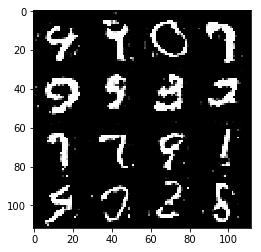

Epoch: 14/20	Step: 12440	 Discriminator Loss: 0.7599	 Generator Loss: 1.4968
Epoch: 14/20	Step: 12460	 Discriminator Loss: 0.7115	 Generator Loss: 1.5909
Epoch: 14/20	Step: 12480	 Discriminator Loss: 0.6839	 Generator Loss: 1.7609
Epoch: 14/20	Step: 12500	 Discriminator Loss: 0.8808	 Generator Loss: 1.2298
Epoch: 14/20	Step: 12520	 Discriminator Loss: 0.5444	 Generator Loss: 2.3183
Epoch: 14/20	Step: 12540	 Discriminator Loss: 0.5050	 Generator Loss: 2.4046
Epoch: 14/20	Step: 12560	 Discriminator Loss: 0.5512	 Generator Loss: 2.1769
Epoch: 14/20	Step: 12580	 Discriminator Loss: 1.3956	 Generator Loss: 0.7236
Epoch: 14/20	Step: 12600	 Discriminator Loss: 0.6381	 Generator Loss: 1.8271
Epoch: 14/20	Step: 12620	 Discriminator Loss: 0.5556	 Generator Loss: 2.0635
Epoch: 14/20	Step: 12640	 Discriminator Loss: 0.5847	 Generator Loss: 2.4532
Epoch: 14/20	Step: 12660	 Discriminator Loss: 0.9969	 Generator Loss: 1.1026
Epoch: 14/20	Step: 12680	 Discriminator Loss: 0.7826	 Generator Loss: 1.4028

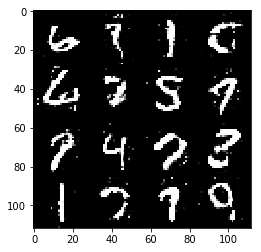

Epoch: 14/20	Step: 12900	 Discriminator Loss: 0.7120	 Generator Loss: 1.9325
Epoch: 14/20	Step: 12920	 Discriminator Loss: 0.6455	 Generator Loss: 2.4461
Epoch: 14/20	Step: 12940	 Discriminator Loss: 0.4822	 Generator Loss: 2.6629
Epoch: 14/20	Step: 12960	 Discriminator Loss: 1.4161	 Generator Loss: 0.6665
Epoch: 14/20	Step: 12980	 Discriminator Loss: 0.6054	 Generator Loss: 1.8819
Epoch: 14/20	Step: 13000	 Discriminator Loss: 0.5528	 Generator Loss: 2.3533
Epoch: 14/20	Step: 13020	 Discriminator Loss: 1.5194	 Generator Loss: 3.6792
Epoch: 14/20	Step: 13040	 Discriminator Loss: 0.6707	 Generator Loss: 2.3226
Epoch: 14/20	Step: 13060	 Discriminator Loss: 1.1011	 Generator Loss: 0.9121
Epoch: 14/20	Step: 13080	 Discriminator Loss: 0.5867	 Generator Loss: 1.8421
Epoch: 14/20	Step: 13100	 Discriminator Loss: 1.1100	 Generator Loss: 2.9087
Epoch: 15/20	Step: 13120	 Discriminator Loss: 0.7282	 Generator Loss: 2.5203
Epoch: 15/20	Step: 13140	 Discriminator Loss: 0.7459	 Generator Loss: 1.7446

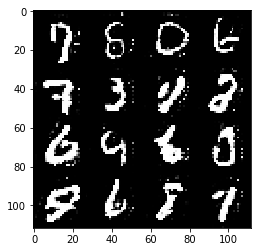

Epoch: 15/20	Step: 13360	 Discriminator Loss: 0.6136	 Generator Loss: 1.9760
Epoch: 15/20	Step: 13380	 Discriminator Loss: 0.5326	 Generator Loss: 2.3369
Epoch: 15/20	Step: 13400	 Discriminator Loss: 0.8607	 Generator Loss: 1.3717
Epoch: 15/20	Step: 13420	 Discriminator Loss: 0.6404	 Generator Loss: 2.0341
Epoch: 15/20	Step: 13440	 Discriminator Loss: 0.8862	 Generator Loss: 1.3066
Epoch: 15/20	Step: 13460	 Discriminator Loss: 0.7642	 Generator Loss: 1.4011
Epoch: 15/20	Step: 13480	 Discriminator Loss: 1.3898	 Generator Loss: 0.7591
Epoch: 15/20	Step: 13500	 Discriminator Loss: 1.2450	 Generator Loss: 0.8385
Epoch: 15/20	Step: 13520	 Discriminator Loss: 0.6982	 Generator Loss: 1.6250
Epoch: 15/20	Step: 13540	 Discriminator Loss: 0.6155	 Generator Loss: 1.8496
Epoch: 15/20	Step: 13560	 Discriminator Loss: 0.7238	 Generator Loss: 1.4955
Epoch: 15/20	Step: 13580	 Discriminator Loss: 1.1472	 Generator Loss: 0.8596
Epoch: 15/20	Step: 13600	 Discriminator Loss: 1.4448	 Generator Loss: 0.6673

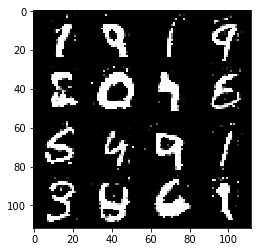

Epoch: 15/20	Step: 13820	 Discriminator Loss: 0.6031	 Generator Loss: 2.1371
Epoch: 15/20	Step: 13840	 Discriminator Loss: 2.5941	 Generator Loss: 0.3098
Epoch: 15/20	Step: 13860	 Discriminator Loss: 0.6818	 Generator Loss: 2.4164
Epoch: 15/20	Step: 13880	 Discriminator Loss: 0.6144	 Generator Loss: 1.8469
Epoch: 15/20	Step: 13900	 Discriminator Loss: 0.6378	 Generator Loss: 1.8144
Epoch: 15/20	Step: 13920	 Discriminator Loss: 0.6186	 Generator Loss: 1.8134
Epoch: 15/20	Step: 13940	 Discriminator Loss: 0.9695	 Generator Loss: 1.1085
Epoch: 15/20	Step: 13960	 Discriminator Loss: 5.9701	 Generator Loss: 8.4750
Epoch: 15/20	Step: 13980	 Discriminator Loss: 1.2237	 Generator Loss: 0.9050
Epoch: 15/20	Step: 14000	 Discriminator Loss: 0.9144	 Generator Loss: 1.3300
Epoch: 15/20	Step: 14020	 Discriminator Loss: 0.8961	 Generator Loss: 1.2019
Epoch: 15/20	Step: 14040	 Discriminator Loss: 0.6965	 Generator Loss: 1.5471
Epoch: 16/20	Step: 14060	 Discriminator Loss: 0.6821	 Generator Loss: 1.9168

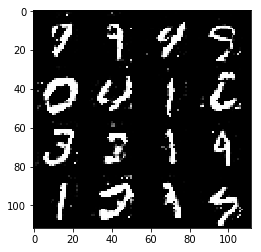

Epoch: 16/20	Step: 14280	 Discriminator Loss: 0.7120	 Generator Loss: 1.5582
Epoch: 16/20	Step: 14300	 Discriminator Loss: 1.0393	 Generator Loss: 0.9920
Epoch: 16/20	Step: 14320	 Discriminator Loss: 0.7254	 Generator Loss: 1.6037
Epoch: 16/20	Step: 14340	 Discriminator Loss: 1.2837	 Generator Loss: 0.8779
Epoch: 16/20	Step: 14360	 Discriminator Loss: 0.8106	 Generator Loss: 1.4089
Epoch: 16/20	Step: 14380	 Discriminator Loss: 0.7426	 Generator Loss: 1.4969
Epoch: 16/20	Step: 14400	 Discriminator Loss: 0.4417	 Generator Loss: 2.7704
Epoch: 16/20	Step: 14420	 Discriminator Loss: 0.7566	 Generator Loss: 1.5169
Epoch: 16/20	Step: 14440	 Discriminator Loss: 0.8853	 Generator Loss: 1.2004
Epoch: 16/20	Step: 14460	 Discriminator Loss: 0.5390	 Generator Loss: 2.2760
Epoch: 16/20	Step: 14480	 Discriminator Loss: 0.5567	 Generator Loss: 3.4178
Epoch: 16/20	Step: 14500	 Discriminator Loss: 1.1364	 Generator Loss: 0.9022
Epoch: 16/20	Step: 14520	 Discriminator Loss: 0.7654	 Generator Loss: 1.7736

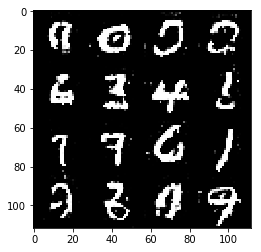

Epoch: 16/20	Step: 14740	 Discriminator Loss: 0.7385	 Generator Loss: 2.3480
Epoch: 16/20	Step: 14760	 Discriminator Loss: 0.6633	 Generator Loss: 2.7550
Epoch: 16/20	Step: 14780	 Discriminator Loss: 0.5269	 Generator Loss: 2.3304
Epoch: 16/20	Step: 14800	 Discriminator Loss: 0.5478	 Generator Loss: 2.6046
Epoch: 16/20	Step: 14820	 Discriminator Loss: 0.7475	 Generator Loss: 1.7291
Epoch: 16/20	Step: 14840	 Discriminator Loss: 5.8424	 Generator Loss: 0.0251
Epoch: 16/20	Step: 14860	 Discriminator Loss: 0.7756	 Generator Loss: 2.0687
Epoch: 16/20	Step: 14880	 Discriminator Loss: 0.9961	 Generator Loss: 1.0544
Epoch: 16/20	Step: 14900	 Discriminator Loss: 0.8817	 Generator Loss: 1.2111
Epoch: 16/20	Step: 14920	 Discriminator Loss: 1.1755	 Generator Loss: 0.8997
Epoch: 16/20	Step: 14940	 Discriminator Loss: 0.8504	 Generator Loss: 2.3554
Epoch: 16/20	Step: 14960	 Discriminator Loss: 0.7381	 Generator Loss: 1.6905
Epoch: 16/20	Step: 14980	 Discriminator Loss: 0.6896	 Generator Loss: 1.6347

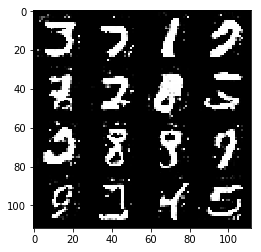

Epoch: 17/20	Step: 15200	 Discriminator Loss: 0.7497	 Generator Loss: 1.5918
Epoch: 17/20	Step: 15220	 Discriminator Loss: 0.8575	 Generator Loss: 1.2044
Epoch: 17/20	Step: 15240	 Discriminator Loss: 0.5327	 Generator Loss: 2.1949
Epoch: 17/20	Step: 15260	 Discriminator Loss: 2.4367	 Generator Loss: 0.8078
Epoch: 17/20	Step: 15280	 Discriminator Loss: 1.3603	 Generator Loss: 3.8072
Epoch: 17/20	Step: 15300	 Discriminator Loss: 0.9300	 Generator Loss: 3.7185
Epoch: 17/20	Step: 15320	 Discriminator Loss: 1.1905	 Generator Loss: 0.9376
Epoch: 17/20	Step: 15340	 Discriminator Loss: 0.6117	 Generator Loss: 2.0278
Epoch: 17/20	Step: 15360	 Discriminator Loss: 0.6068	 Generator Loss: 2.0269
Epoch: 17/20	Step: 15380	 Discriminator Loss: 0.6684	 Generator Loss: 1.8269
Epoch: 17/20	Step: 15400	 Discriminator Loss: 0.5974	 Generator Loss: 2.0180
Epoch: 17/20	Step: 15420	 Discriminator Loss: 3.6783	 Generator Loss: 0.0904
Epoch: 17/20	Step: 15440	 Discriminator Loss: 1.3968	 Generator Loss: 3.6521

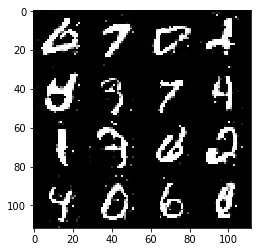

Epoch: 17/20	Step: 15660	 Discriminator Loss: 0.9177	 Generator Loss: 1.2002
Epoch: 17/20	Step: 15680	 Discriminator Loss: 0.9497	 Generator Loss: 1.1796
Epoch: 17/20	Step: 15700	 Discriminator Loss: 1.1834	 Generator Loss: 0.7344
Epoch: 17/20	Step: 15720	 Discriminator Loss: 0.7135	 Generator Loss: 1.6174
Epoch: 17/20	Step: 15740	 Discriminator Loss: 0.7641	 Generator Loss: 1.5117
Epoch: 17/20	Step: 15760	 Discriminator Loss: 0.5443	 Generator Loss: 2.2689
Epoch: 17/20	Step: 15780	 Discriminator Loss: 1.3628	 Generator Loss: 0.7775
Epoch: 17/20	Step: 15800	 Discriminator Loss: 0.6465	 Generator Loss: 2.1940
Epoch: 17/20	Step: 15820	 Discriminator Loss: 0.6484	 Generator Loss: 1.7514
Epoch: 17/20	Step: 15840	 Discriminator Loss: 1.4463	 Generator Loss: 0.6369
Epoch: 17/20	Step: 15860	 Discriminator Loss: 0.4431	 Generator Loss: 3.2724
Epoch: 17/20	Step: 15880	 Discriminator Loss: 0.6226	 Generator Loss: 1.9152
Epoch: 17/20	Step: 15900	 Discriminator Loss: 0.6505	 Generator Loss: 2.6897

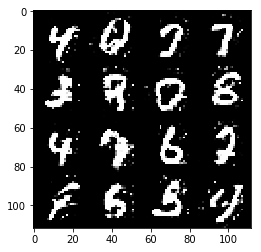

Epoch: 18/20	Step: 16120	 Discriminator Loss: 0.6044	 Generator Loss: 1.9566
Epoch: 18/20	Step: 16140	 Discriminator Loss: 0.4770	 Generator Loss: 2.7923
Epoch: 18/20	Step: 16160	 Discriminator Loss: 0.5100	 Generator Loss: 2.6525
Epoch: 18/20	Step: 16180	 Discriminator Loss: 1.9491	 Generator Loss: 0.4118
Epoch: 18/20	Step: 16200	 Discriminator Loss: 1.9356	 Generator Loss: 0.4422
Epoch: 18/20	Step: 16220	 Discriminator Loss: 0.7482	 Generator Loss: 1.5939
Epoch: 18/20	Step: 16240	 Discriminator Loss: 0.6451	 Generator Loss: 1.9189
Epoch: 18/20	Step: 16260	 Discriminator Loss: 0.7690	 Generator Loss: 1.4336
Epoch: 18/20	Step: 16280	 Discriminator Loss: 0.5073	 Generator Loss: 2.4630
Epoch: 18/20	Step: 16300	 Discriminator Loss: 0.4689	 Generator Loss: 2.9100
Epoch: 18/20	Step: 16320	 Discriminator Loss: 0.8699	 Generator Loss: 1.3932
Epoch: 18/20	Step: 16340	 Discriminator Loss: 0.4658	 Generator Loss: 2.5713
Epoch: 18/20	Step: 16360	 Discriminator Loss: 5.9718	 Generator Loss: 0.0413

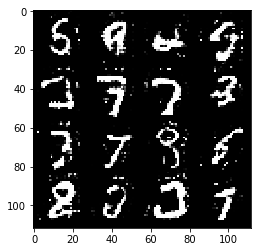

Epoch: 18/20	Step: 16580	 Discriminator Loss: 0.6258	 Generator Loss: 1.9340
Epoch: 18/20	Step: 16600	 Discriminator Loss: 1.0844	 Generator Loss: 3.7703
Epoch: 18/20	Step: 16620	 Discriminator Loss: 0.7313	 Generator Loss: 1.6161
Epoch: 18/20	Step: 16640	 Discriminator Loss: 0.8232	 Generator Loss: 1.4322
Epoch: 18/20	Step: 16660	 Discriminator Loss: 0.8082	 Generator Loss: 1.4487
Epoch: 18/20	Step: 16680	 Discriminator Loss: 0.7313	 Generator Loss: 3.6787
Epoch: 18/20	Step: 16700	 Discriminator Loss: 1.1845	 Generator Loss: 0.8859
Epoch: 18/20	Step: 16720	 Discriminator Loss: 0.7976	 Generator Loss: 1.4275
Epoch: 18/20	Step: 16740	 Discriminator Loss: 0.6129	 Generator Loss: 1.9430
Epoch: 18/20	Step: 16760	 Discriminator Loss: 0.4726	 Generator Loss: 3.2973
Epoch: 18/20	Step: 16780	 Discriminator Loss: 4.5029	 Generator Loss: 0.1280
Epoch: 18/20	Step: 16800	 Discriminator Loss: 1.0492	 Generator Loss: 0.9390
Epoch: 18/20	Step: 16820	 Discriminator Loss: 0.7318	 Generator Loss: 1.6314

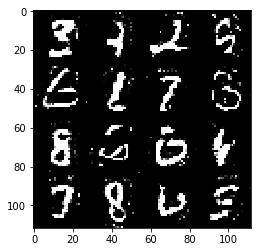

Epoch: 19/20	Step: 17040	 Discriminator Loss: 0.6858	 Generator Loss: 1.6356
Epoch: 19/20	Step: 17060	 Discriminator Loss: 0.6802	 Generator Loss: 1.6303
Epoch: 19/20	Step: 17080	 Discriminator Loss: 0.6241	 Generator Loss: 1.8632
Epoch: 19/20	Step: 17100	 Discriminator Loss: 0.6034	 Generator Loss: 1.8333
Epoch: 19/20	Step: 17120	 Discriminator Loss: 0.6598	 Generator Loss: 1.7546
Epoch: 19/20	Step: 17140	 Discriminator Loss: 0.7343	 Generator Loss: 1.4667
Epoch: 19/20	Step: 17160	 Discriminator Loss: 0.7292	 Generator Loss: 1.6133
Epoch: 19/20	Step: 17180	 Discriminator Loss: 0.9526	 Generator Loss: 1.1703
Epoch: 19/20	Step: 17200	 Discriminator Loss: 0.5163	 Generator Loss: 2.2760
Epoch: 19/20	Step: 17220	 Discriminator Loss: 0.7081	 Generator Loss: 1.8076
Epoch: 19/20	Step: 17240	 Discriminator Loss: 0.4485	 Generator Loss: 3.1552
Epoch: 19/20	Step: 17260	 Discriminator Loss: 0.6076	 Generator Loss: 2.0389
Epoch: 19/20	Step: 17280	 Discriminator Loss: 0.4744	 Generator Loss: 3.1573

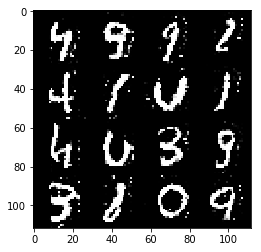

Epoch: 19/20	Step: 17500	 Discriminator Loss: 0.4422	 Generator Loss: 3.4094
Epoch: 19/20	Step: 17520	 Discriminator Loss: 0.5786	 Generator Loss: 2.2979
Epoch: 19/20	Step: 17540	 Discriminator Loss: 2.4084	 Generator Loss: 4.4641
Epoch: 19/20	Step: 17560	 Discriminator Loss: 0.6631	 Generator Loss: 1.8793
Epoch: 19/20	Step: 17580	 Discriminator Loss: 0.6401	 Generator Loss: 3.0254
Epoch: 19/20	Step: 17600	 Discriminator Loss: 1.5426	 Generator Loss: 0.6559
Epoch: 19/20	Step: 17620	 Discriminator Loss: 0.6328	 Generator Loss: 1.8499
Epoch: 19/20	Step: 17640	 Discriminator Loss: 0.6120	 Generator Loss: 1.9167
Epoch: 19/20	Step: 17660	 Discriminator Loss: 0.7605	 Generator Loss: 1.6137
Epoch: 19/20	Step: 17680	 Discriminator Loss: 0.6329	 Generator Loss: 1.8973
Epoch: 19/20	Step: 17700	 Discriminator Loss: 1.0573	 Generator Loss: 1.2560
Epoch: 19/20	Step: 17720	 Discriminator Loss: 0.4753	 Generator Loss: 2.6815
Epoch: 19/20	Step: 17740	 Discriminator Loss: 0.9337	 Generator Loss: 1.0274

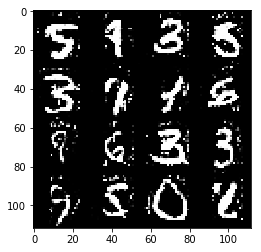

Epoch: 20/20	Step: 17960	 Discriminator Loss: 0.6483	 Generator Loss: 1.8422
Epoch: 20/20	Step: 17980	 Discriminator Loss: 0.5759	 Generator Loss: 2.1750
Epoch: 20/20	Step: 18000	 Discriminator Loss: 1.0895	 Generator Loss: 0.9965
Epoch: 20/20	Step: 18020	 Discriminator Loss: 0.5136	 Generator Loss: 2.3223
Epoch: 20/20	Step: 18040	 Discriminator Loss: 0.7491	 Generator Loss: 1.5404
Epoch: 20/20	Step: 18060	 Discriminator Loss: 1.0624	 Generator Loss: 3.9729
Epoch: 20/20	Step: 18080	 Discriminator Loss: 0.6069	 Generator Loss: 1.8675
Epoch: 20/20	Step: 18100	 Discriminator Loss: 1.3025	 Generator Loss: 0.8265
Epoch: 20/20	Step: 18120	 Discriminator Loss: 1.0399	 Generator Loss: 2.6434
Epoch: 20/20	Step: 18140	 Discriminator Loss: 1.0658	 Generator Loss: 1.0275
Epoch: 20/20	Step: 18160	 Discriminator Loss: 0.7488	 Generator Loss: 1.4984
Epoch: 20/20	Step: 18180	 Discriminator Loss: 0.6868	 Generator Loss: 1.7479
Epoch: 20/20	Step: 18200	 Discriminator Loss: 0.7479	 Generator Loss: 1.5180

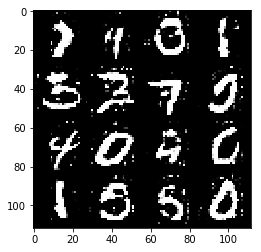

Epoch: 20/20	Step: 18420	 Discriminator Loss: 0.6099	 Generator Loss: 1.9648
Epoch: 20/20	Step: 18440	 Discriminator Loss: 0.4762	 Generator Loss: 2.5647
Epoch: 20/20	Step: 18460	 Discriminator Loss: 0.7248	 Generator Loss: 1.5403
Epoch: 20/20	Step: 18480	 Discriminator Loss: 0.5707	 Generator Loss: 2.0534
Epoch: 20/20	Step: 18500	 Discriminator Loss: 0.7391	 Generator Loss: 1.4938
Epoch: 20/20	Step: 18520	 Discriminator Loss: 0.5636	 Generator Loss: 2.4570
Epoch: 20/20	Step: 18540	 Discriminator Loss: 1.0780	 Generator Loss: 1.0469
Epoch: 20/20	Step: 18560	 Discriminator Loss: 1.2037	 Generator Loss: 0.9002
Epoch: 20/20	Step: 18580	 Discriminator Loss: 0.7341	 Generator Loss: 1.6000
Epoch: 20/20	Step: 18600	 Discriminator Loss: 1.6771	 Generator Loss: 0.5756
Epoch: 20/20	Step: 18620	 Discriminator Loss: 0.7277	 Generator Loss: 1.5456
Epoch: 20/20	Step: 18640	 Discriminator Loss: 1.1457	 Generator Loss: 1.0011
Epoch: 20/20	Step: 18660	 Discriminator Loss: 0.7660	 Generator Loss: 1.4597

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2
alpha = 0.1
smooth = 0.1
keep_prob = 0.8

print_every = 20
show_every = 460


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          print_every=print_every, show_every=show_every, alpha=alpha, smooth=smooth, keep_prob=keep_prob) # Some params added

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/10	Step: 20	 Discriminator Loss: 5.4661	 Generator Loss: 0.0084
Epoch: 1/10	Step: 40	 Discriminator Loss: 2.5770	 Generator Loss: 0.1370
Epoch: 1/10	Step: 60	 Discriminator Loss: 2.5797	 Generator Loss: 0.1366
Epoch: 1/10	Step: 80	 Discriminator Loss: 2.1019	 Generator Loss: 0.2248
Epoch: 1/10	Step: 100	 Discriminator Loss: 1.5529	 Generator Loss: 0.4147
Epoch: 1/10	Step: 120	 Discriminator Loss: 1.7852	 Generator Loss: 0.2896
Epoch: 1/10	Step: 140	 Discriminator Loss: 0.4803	 Generator Loss: 2.3612
Epoch: 1/10	Step: 160	 Discriminator Loss: 2.9247	 Generator Loss: 4.4591
Epoch: 1/10	Step: 180	 Discriminator Loss: 0.7277	 Generator Loss: 1.7816
Epoch: 1/10	Step: 200	 Discriminator Loss: 0.6128	 Generator Loss: 2.2080
Epoch: 1/10	Step: 220	 Discriminator Loss: 1.3603	 Generator Loss: 0.9491
Epoch: 1/10	Step: 240	 Discriminator Loss: 2.2978	 Generator Loss: 2.5217
Epoch: 1/10	Step: 260	 Discriminator Loss: 3.0128	 Generator Loss: 2.8196
Epoch: 1/10	Step: 280	 Discriminator Loss:

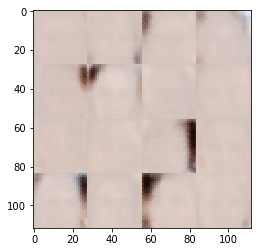

Epoch: 1/10	Step: 520	 Discriminator Loss: 1.5546	 Generator Loss: 0.3913
Epoch: 1/10	Step: 540	 Discriminator Loss: 1.2237	 Generator Loss: 0.6691
Epoch: 1/10	Step: 560	 Discriminator Loss: 0.6253	 Generator Loss: 3.5826
Epoch: 1/10	Step: 580	 Discriminator Loss: 1.8703	 Generator Loss: 1.9763
Epoch: 1/10	Step: 600	 Discriminator Loss: 1.4395	 Generator Loss: 0.5542
Epoch: 1/10	Step: 620	 Discriminator Loss: 1.5454	 Generator Loss: 0.4362
Epoch: 1/10	Step: 640	 Discriminator Loss: 1.4457	 Generator Loss: 0.4837
Epoch: 1/10	Step: 660	 Discriminator Loss: 0.9553	 Generator Loss: 1.0964
Epoch: 1/10	Step: 680	 Discriminator Loss: 1.4385	 Generator Loss: 0.5584
Epoch: 1/10	Step: 700	 Discriminator Loss: 1.6367	 Generator Loss: 0.9794
Epoch: 1/10	Step: 720	 Discriminator Loss: 1.4299	 Generator Loss: 0.4851
Epoch: 1/10	Step: 740	 Discriminator Loss: 1.5121	 Generator Loss: 0.9287
Epoch: 1/10	Step: 760	 Discriminator Loss: 1.3880	 Generator Loss: 0.9118
Epoch: 1/10	Step: 780	 Discriminator L

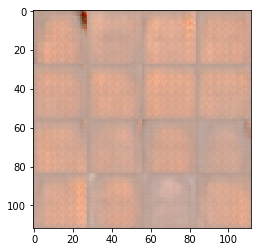

Epoch: 1/10	Step: 1020	 Discriminator Loss: 1.5085	 Generator Loss: 0.5694
Epoch: 1/10	Step: 1040	 Discriminator Loss: 1.3655	 Generator Loss: 0.6492
Epoch: 1/10	Step: 1060	 Discriminator Loss: 1.1763	 Generator Loss: 0.8381
Epoch: 1/10	Step: 1080	 Discriminator Loss: 1.3001	 Generator Loss: 0.6099
Epoch: 1/10	Step: 1100	 Discriminator Loss: 1.1107	 Generator Loss: 0.8572
Epoch: 1/10	Step: 1120	 Discriminator Loss: 1.4239	 Generator Loss: 0.7509
Epoch: 1/10	Step: 1140	 Discriminator Loss: 1.5921	 Generator Loss: 1.3241
Epoch: 1/10	Step: 1160	 Discriminator Loss: 1.3632	 Generator Loss: 1.0100
Epoch: 1/10	Step: 1180	 Discriminator Loss: 1.5705	 Generator Loss: 0.9410
Epoch: 1/10	Step: 1200	 Discriminator Loss: 1.4953	 Generator Loss: 0.4998
Epoch: 1/10	Step: 1220	 Discriminator Loss: 1.3934	 Generator Loss: 0.6268
Epoch: 1/10	Step: 1240	 Discriminator Loss: 1.4358	 Generator Loss: 0.5646
Epoch: 1/10	Step: 1260	 Discriminator Loss: 1.5305	 Generator Loss: 1.3189
Epoch: 1/10	Step: 1280	 D

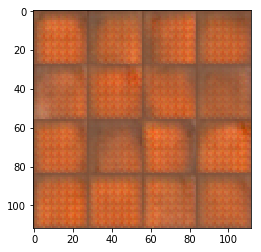

Epoch: 1/10	Step: 1520	 Discriminator Loss: 1.2647	 Generator Loss: 0.7504
Epoch: 1/10	Step: 1540	 Discriminator Loss: 1.3912	 Generator Loss: 1.0977
Epoch: 1/10	Step: 1560	 Discriminator Loss: 1.3896	 Generator Loss: 0.6159
Epoch: 1/10	Step: 1580	 Discriminator Loss: 1.3716	 Generator Loss: 0.9595
Epoch: 1/10	Step: 1600	 Discriminator Loss: 1.4306	 Generator Loss: 1.1088
Epoch: 1/10	Step: 1620	 Discriminator Loss: 1.2246	 Generator Loss: 0.7749
Epoch: 1/10	Step: 1640	 Discriminator Loss: 1.5013	 Generator Loss: 0.5041
Epoch: 1/10	Step: 1660	 Discriminator Loss: 1.3895	 Generator Loss: 0.7483
Epoch: 1/10	Step: 1680	 Discriminator Loss: 1.3641	 Generator Loss: 0.9026
Epoch: 1/10	Step: 1700	 Discriminator Loss: 1.3856	 Generator Loss: 0.8213
Epoch: 1/10	Step: 1720	 Discriminator Loss: 1.3417	 Generator Loss: 0.6931
Epoch: 1/10	Step: 1740	 Discriminator Loss: 1.3750	 Generator Loss: 0.6990
Epoch: 1/10	Step: 1760	 Discriminator Loss: 1.4313	 Generator Loss: 0.5918
Epoch: 1/10	Step: 1780	 D

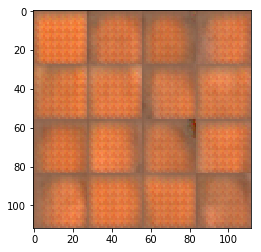

Epoch: 1/10	Step: 2020	 Discriminator Loss: 1.4448	 Generator Loss: 0.5107
Epoch: 1/10	Step: 2040	 Discriminator Loss: 1.3363	 Generator Loss: 0.7236
Epoch: 1/10	Step: 2060	 Discriminator Loss: 1.3932	 Generator Loss: 0.9941
Epoch: 1/10	Step: 2080	 Discriminator Loss: 1.3252	 Generator Loss: 0.7347
Epoch: 1/10	Step: 2100	 Discriminator Loss: 1.3025	 Generator Loss: 0.8918
Epoch: 1/10	Step: 2120	 Discriminator Loss: 1.4396	 Generator Loss: 0.8136
Epoch: 1/10	Step: 2140	 Discriminator Loss: 1.5538	 Generator Loss: 0.4306
Epoch: 1/10	Step: 2160	 Discriminator Loss: 1.4363	 Generator Loss: 0.7477
Epoch: 1/10	Step: 2180	 Discriminator Loss: 1.5555	 Generator Loss: 0.4146
Epoch: 1/10	Step: 2200	 Discriminator Loss: 1.3266	 Generator Loss: 0.8278
Epoch: 1/10	Step: 2220	 Discriminator Loss: 1.7782	 Generator Loss: 1.4959
Epoch: 1/10	Step: 2240	 Discriminator Loss: 1.4652	 Generator Loss: 0.5898
Epoch: 1/10	Step: 2260	 Discriminator Loss: 1.4103	 Generator Loss: 0.5402
Epoch: 1/10	Step: 2280	 D

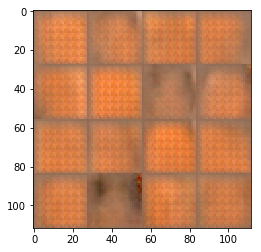

Epoch: 1/10	Step: 2520	 Discriminator Loss: 1.3336	 Generator Loss: 0.7020
Epoch: 1/10	Step: 2540	 Discriminator Loss: 2.2237	 Generator Loss: 1.6102
Epoch: 1/10	Step: 2560	 Discriminator Loss: 1.3870	 Generator Loss: 0.9877
Epoch: 1/10	Step: 2580	 Discriminator Loss: 1.3994	 Generator Loss: 1.0112
Epoch: 1/10	Step: 2600	 Discriminator Loss: 1.4256	 Generator Loss: 0.5909
Epoch: 1/10	Step: 2620	 Discriminator Loss: 1.4364	 Generator Loss: 0.6123
Epoch: 1/10	Step: 2640	 Discriminator Loss: 1.4646	 Generator Loss: 0.5271
Epoch: 1/10	Step: 2660	 Discriminator Loss: 1.4444	 Generator Loss: 0.9302
Epoch: 1/10	Step: 2680	 Discriminator Loss: 1.4172	 Generator Loss: 0.6145
Epoch: 1/10	Step: 2700	 Discriminator Loss: 1.3450	 Generator Loss: 0.6983
Epoch: 1/10	Step: 2720	 Discriminator Loss: 1.4725	 Generator Loss: 0.6149
Epoch: 1/10	Step: 2740	 Discriminator Loss: 1.2856	 Generator Loss: 0.6873
Epoch: 1/10	Step: 2760	 Discriminator Loss: 1.5201	 Generator Loss: 0.6281
Epoch: 1/10	Step: 2780	 D

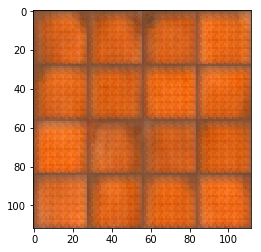

Epoch: 1/10	Step: 3020	 Discriminator Loss: 1.5345	 Generator Loss: 0.4317
Epoch: 1/10	Step: 3040	 Discriminator Loss: 1.4819	 Generator Loss: 0.5383
Epoch: 1/10	Step: 3060	 Discriminator Loss: 1.4402	 Generator Loss: 0.7594
Epoch: 1/10	Step: 3080	 Discriminator Loss: 1.2434	 Generator Loss: 0.9213
Epoch: 1/10	Step: 3100	 Discriminator Loss: 1.4162	 Generator Loss: 0.6085
Epoch: 1/10	Step: 3120	 Discriminator Loss: 1.3164	 Generator Loss: 0.7414
Epoch: 1/10	Step: 3140	 Discriminator Loss: 1.2767	 Generator Loss: 0.8518
Epoch: 1/10	Step: 3160	 Discriminator Loss: 1.4281	 Generator Loss: 0.5888
Epoch: 2/10	Step: 3180	 Discriminator Loss: 1.3996	 Generator Loss: 0.8167
Epoch: 2/10	Step: 3200	 Discriminator Loss: 1.6501	 Generator Loss: 0.3782
Epoch: 2/10	Step: 3220	 Discriminator Loss: 1.4537	 Generator Loss: 0.9054
Epoch: 2/10	Step: 3240	 Discriminator Loss: 1.3059	 Generator Loss: 0.7350
Epoch: 2/10	Step: 3260	 Discriminator Loss: 1.3983	 Generator Loss: 1.1328
Epoch: 2/10	Step: 3280	 D

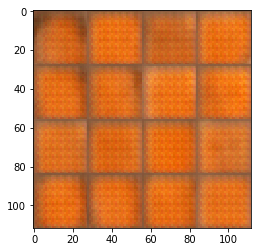

Epoch: 2/10	Step: 3520	 Discriminator Loss: 1.5059	 Generator Loss: 0.4871
Epoch: 2/10	Step: 3540	 Discriminator Loss: 1.4803	 Generator Loss: 0.5145
Epoch: 2/10	Step: 3560	 Discriminator Loss: 1.4063	 Generator Loss: 0.5568
Epoch: 2/10	Step: 3580	 Discriminator Loss: 1.4174	 Generator Loss: 0.5364
Epoch: 2/10	Step: 3600	 Discriminator Loss: 1.2902	 Generator Loss: 1.0374
Epoch: 2/10	Step: 3620	 Discriminator Loss: 1.4608	 Generator Loss: 0.9718
Epoch: 2/10	Step: 3640	 Discriminator Loss: 1.3675	 Generator Loss: 0.6967
Epoch: 2/10	Step: 3660	 Discriminator Loss: 1.4914	 Generator Loss: 0.5007
Epoch: 2/10	Step: 3680	 Discriminator Loss: 1.3674	 Generator Loss: 0.7496
Epoch: 2/10	Step: 3700	 Discriminator Loss: 1.5170	 Generator Loss: 0.5386
Epoch: 2/10	Step: 3720	 Discriminator Loss: 1.3668	 Generator Loss: 0.6969
Epoch: 2/10	Step: 3740	 Discriminator Loss: 1.3603	 Generator Loss: 0.7651
Epoch: 2/10	Step: 3760	 Discriminator Loss: 1.3547	 Generator Loss: 0.7408
Epoch: 2/10	Step: 3780	 D

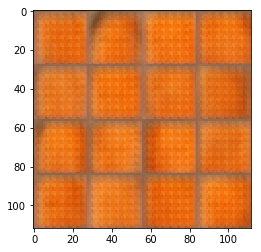

Epoch: 2/10	Step: 4020	 Discriminator Loss: 1.4155	 Generator Loss: 0.6200
Epoch: 2/10	Step: 4040	 Discriminator Loss: 1.3794	 Generator Loss: 0.7964
Epoch: 2/10	Step: 4060	 Discriminator Loss: 1.4794	 Generator Loss: 0.7077
Epoch: 2/10	Step: 4080	 Discriminator Loss: 1.6325	 Generator Loss: 0.5045
Epoch: 2/10	Step: 4100	 Discriminator Loss: 1.4587	 Generator Loss: 0.4881
Epoch: 2/10	Step: 4120	 Discriminator Loss: 1.4389	 Generator Loss: 0.5515
Epoch: 2/10	Step: 4140	 Discriminator Loss: 1.3668	 Generator Loss: 0.6035
Epoch: 2/10	Step: 4160	 Discriminator Loss: 1.4059	 Generator Loss: 0.7834
Epoch: 2/10	Step: 4180	 Discriminator Loss: 1.5420	 Generator Loss: 0.4627
Epoch: 2/10	Step: 4200	 Discriminator Loss: 1.4423	 Generator Loss: 0.7255
Epoch: 2/10	Step: 4220	 Discriminator Loss: 1.4125	 Generator Loss: 0.7681
Epoch: 2/10	Step: 4240	 Discriminator Loss: 1.4406	 Generator Loss: 0.8161
Epoch: 2/10	Step: 4260	 Discriminator Loss: 1.4504	 Generator Loss: 0.7905
Epoch: 2/10	Step: 4280	 D

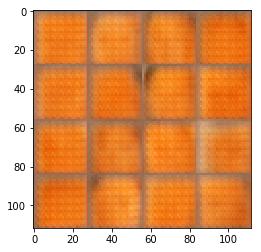

Epoch: 2/10	Step: 4520	 Discriminator Loss: 1.4263	 Generator Loss: 0.9199
Epoch: 2/10	Step: 4540	 Discriminator Loss: 1.4430	 Generator Loss: 0.9744
Epoch: 2/10	Step: 4560	 Discriminator Loss: 1.3608	 Generator Loss: 0.6312
Epoch: 2/10	Step: 4580	 Discriminator Loss: 1.3022	 Generator Loss: 0.9226
Epoch: 2/10	Step: 4600	 Discriminator Loss: 1.3655	 Generator Loss: 0.6699
Epoch: 2/10	Step: 4620	 Discriminator Loss: 1.4473	 Generator Loss: 0.5293
Epoch: 2/10	Step: 4640	 Discriminator Loss: 1.5900	 Generator Loss: 1.0348
Epoch: 2/10	Step: 4660	 Discriminator Loss: 1.1634	 Generator Loss: 1.1207
Epoch: 2/10	Step: 4680	 Discriminator Loss: 1.2902	 Generator Loss: 0.8838
Epoch: 2/10	Step: 4700	 Discriminator Loss: 1.4648	 Generator Loss: 0.7741
Epoch: 2/10	Step: 4720	 Discriminator Loss: 1.4008	 Generator Loss: 0.6272
Epoch: 2/10	Step: 4740	 Discriminator Loss: 1.3659	 Generator Loss: 0.6909
Epoch: 2/10	Step: 4760	 Discriminator Loss: 1.4338	 Generator Loss: 0.6306
Epoch: 2/10	Step: 4780	 D

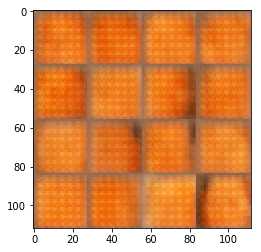

Epoch: 2/10	Step: 5020	 Discriminator Loss: 1.4271	 Generator Loss: 0.7499
Epoch: 2/10	Step: 5040	 Discriminator Loss: 1.3997	 Generator Loss: 0.7528
Epoch: 2/10	Step: 5060	 Discriminator Loss: 1.4504	 Generator Loss: 0.5351
Epoch: 2/10	Step: 5080	 Discriminator Loss: 1.4001	 Generator Loss: 0.7103
Epoch: 2/10	Step: 5100	 Discriminator Loss: 1.4666	 Generator Loss: 0.7014
Epoch: 2/10	Step: 5120	 Discriminator Loss: 1.3994	 Generator Loss: 0.7342
Epoch: 2/10	Step: 5140	 Discriminator Loss: 1.4134	 Generator Loss: 0.6415
Epoch: 2/10	Step: 5160	 Discriminator Loss: 1.3293	 Generator Loss: 0.7253
Epoch: 2/10	Step: 5180	 Discriminator Loss: 1.4185	 Generator Loss: 0.7622
Epoch: 2/10	Step: 5200	 Discriminator Loss: 1.3874	 Generator Loss: 0.6894
Epoch: 2/10	Step: 5220	 Discriminator Loss: 1.4650	 Generator Loss: 0.6316
Epoch: 2/10	Step: 5240	 Discriminator Loss: 1.3923	 Generator Loss: 0.7272
Epoch: 2/10	Step: 5260	 Discriminator Loss: 1.4310	 Generator Loss: 0.5649
Epoch: 2/10	Step: 5280	 D

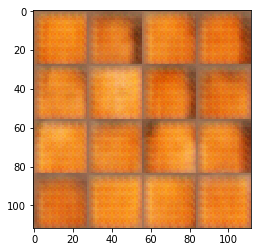

Epoch: 2/10	Step: 5520	 Discriminator Loss: 1.3549	 Generator Loss: 0.6543
Epoch: 2/10	Step: 5540	 Discriminator Loss: 1.3636	 Generator Loss: 0.7546
Epoch: 2/10	Step: 5560	 Discriminator Loss: 1.3814	 Generator Loss: 0.7520
Epoch: 2/10	Step: 5580	 Discriminator Loss: 1.3782	 Generator Loss: 0.6740
Epoch: 2/10	Step: 5600	 Discriminator Loss: 1.2141	 Generator Loss: 0.7773
Epoch: 2/10	Step: 5620	 Discriminator Loss: 1.3793	 Generator Loss: 0.7384
Epoch: 2/10	Step: 5640	 Discriminator Loss: 1.4509	 Generator Loss: 0.6133
Epoch: 2/10	Step: 5660	 Discriminator Loss: 1.4487	 Generator Loss: 0.6154
Epoch: 2/10	Step: 5680	 Discriminator Loss: 1.4268	 Generator Loss: 0.6356
Epoch: 2/10	Step: 5700	 Discriminator Loss: 1.3499	 Generator Loss: 0.8870
Epoch: 2/10	Step: 5720	 Discriminator Loss: 1.4387	 Generator Loss: 0.5965
Epoch: 2/10	Step: 5740	 Discriminator Loss: 1.3930	 Generator Loss: 0.7276
Epoch: 2/10	Step: 5760	 Discriminator Loss: 1.4053	 Generator Loss: 0.8983
Epoch: 2/10	Step: 5780	 D

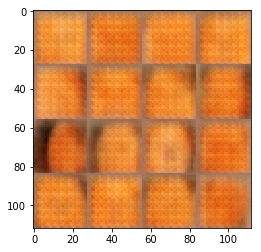

Epoch: 2/10	Step: 6020	 Discriminator Loss: 1.4431	 Generator Loss: 0.9089
Epoch: 2/10	Step: 6040	 Discriminator Loss: 1.3646	 Generator Loss: 0.6766
Epoch: 2/10	Step: 6060	 Discriminator Loss: 1.3562	 Generator Loss: 0.7974
Epoch: 2/10	Step: 6080	 Discriminator Loss: 1.3785	 Generator Loss: 0.8753
Epoch: 2/10	Step: 6100	 Discriminator Loss: 1.3726	 Generator Loss: 0.7501
Epoch: 2/10	Step: 6120	 Discriminator Loss: 1.3955	 Generator Loss: 0.8762
Epoch: 2/10	Step: 6140	 Discriminator Loss: 1.3927	 Generator Loss: 0.9027
Epoch: 2/10	Step: 6160	 Discriminator Loss: 1.4413	 Generator Loss: 0.5998
Epoch: 2/10	Step: 6180	 Discriminator Loss: 1.3782	 Generator Loss: 0.9631
Epoch: 2/10	Step: 6200	 Discriminator Loss: 1.4276	 Generator Loss: 0.8271
Epoch: 2/10	Step: 6220	 Discriminator Loss: 1.3956	 Generator Loss: 1.0601
Epoch: 2/10	Step: 6240	 Discriminator Loss: 1.3932	 Generator Loss: 0.7223
Epoch: 2/10	Step: 6260	 Discriminator Loss: 1.3360	 Generator Loss: 0.8774
Epoch: 2/10	Step: 6280	 D

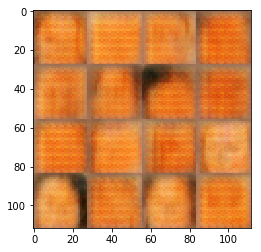

Epoch: 3/10	Step: 6520	 Discriminator Loss: 1.2332	 Generator Loss: 1.0060
Epoch: 3/10	Step: 6540	 Discriminator Loss: 1.3300	 Generator Loss: 0.7907
Epoch: 3/10	Step: 6560	 Discriminator Loss: 1.3369	 Generator Loss: 0.6297
Epoch: 3/10	Step: 6580	 Discriminator Loss: 1.3833	 Generator Loss: 0.7277
Epoch: 3/10	Step: 6600	 Discriminator Loss: 1.3635	 Generator Loss: 0.6913
Epoch: 3/10	Step: 6620	 Discriminator Loss: 1.5775	 Generator Loss: 0.4240
Epoch: 3/10	Step: 6640	 Discriminator Loss: 1.4091	 Generator Loss: 0.6112
Epoch: 3/10	Step: 6660	 Discriminator Loss: 1.3837	 Generator Loss: 0.7891
Epoch: 3/10	Step: 6680	 Discriminator Loss: 1.5294	 Generator Loss: 0.8295
Epoch: 3/10	Step: 6700	 Discriminator Loss: 1.2930	 Generator Loss: 0.8089
Epoch: 3/10	Step: 6720	 Discriminator Loss: 1.5815	 Generator Loss: 0.4413
Epoch: 3/10	Step: 6740	 Discriminator Loss: 1.3463	 Generator Loss: 0.6949
Epoch: 3/10	Step: 6760	 Discriminator Loss: 1.4060	 Generator Loss: 0.7329
Epoch: 3/10	Step: 6780	 D

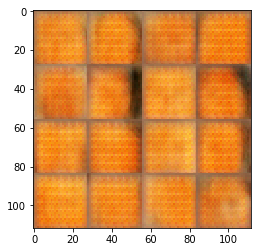

Epoch: 3/10	Step: 7020	 Discriminator Loss: 1.3817	 Generator Loss: 0.6772
Epoch: 3/10	Step: 7040	 Discriminator Loss: 1.3936	 Generator Loss: 0.7470
Epoch: 3/10	Step: 7060	 Discriminator Loss: 1.3403	 Generator Loss: 0.7344
Epoch: 3/10	Step: 7080	 Discriminator Loss: 1.4044	 Generator Loss: 0.6728
Epoch: 3/10	Step: 7100	 Discriminator Loss: 1.3545	 Generator Loss: 0.8712
Epoch: 3/10	Step: 7120	 Discriminator Loss: 1.3556	 Generator Loss: 0.7322
Epoch: 3/10	Step: 7140	 Discriminator Loss: 1.2734	 Generator Loss: 0.7578
Epoch: 3/10	Step: 7160	 Discriminator Loss: 1.3601	 Generator Loss: 0.6802
Epoch: 3/10	Step: 7180	 Discriminator Loss: 1.3915	 Generator Loss: 0.6990
Epoch: 3/10	Step: 7200	 Discriminator Loss: 1.3580	 Generator Loss: 0.7302
Epoch: 3/10	Step: 7220	 Discriminator Loss: 1.4972	 Generator Loss: 0.5417
Epoch: 3/10	Step: 7240	 Discriminator Loss: 1.3838	 Generator Loss: 0.6797
Epoch: 3/10	Step: 7260	 Discriminator Loss: 1.3748	 Generator Loss: 0.8498
Epoch: 3/10	Step: 7280	 D

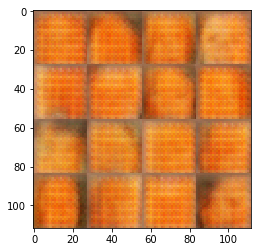

Epoch: 3/10	Step: 7520	 Discriminator Loss: 1.6066	 Generator Loss: 1.1804
Epoch: 3/10	Step: 7540	 Discriminator Loss: 1.4445	 Generator Loss: 0.8129
Epoch: 3/10	Step: 7560	 Discriminator Loss: 1.4052	 Generator Loss: 0.6573
Epoch: 3/10	Step: 7580	 Discriminator Loss: 1.3609	 Generator Loss: 0.9064
Epoch: 3/10	Step: 7600	 Discriminator Loss: 1.3669	 Generator Loss: 0.7650
Epoch: 3/10	Step: 7620	 Discriminator Loss: 1.3513	 Generator Loss: 0.7940
Epoch: 3/10	Step: 7640	 Discriminator Loss: 1.3388	 Generator Loss: 0.7373
Epoch: 3/10	Step: 7660	 Discriminator Loss: 1.2048	 Generator Loss: 0.8170
Epoch: 3/10	Step: 7680	 Discriminator Loss: 1.2762	 Generator Loss: 0.8446
Epoch: 3/10	Step: 7700	 Discriminator Loss: 1.3551	 Generator Loss: 0.6999
Epoch: 3/10	Step: 7720	 Discriminator Loss: 1.4114	 Generator Loss: 0.7354
Epoch: 3/10	Step: 7740	 Discriminator Loss: 1.3733	 Generator Loss: 0.6867
Epoch: 3/10	Step: 7760	 Discriminator Loss: 1.1983	 Generator Loss: 0.9302
Epoch: 3/10	Step: 7780	 D

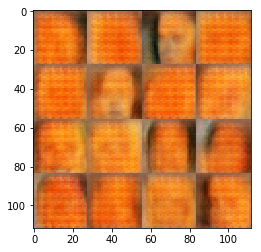

Epoch: 3/10	Step: 8020	 Discriminator Loss: 1.4353	 Generator Loss: 0.6784
Epoch: 3/10	Step: 8040	 Discriminator Loss: 1.2867	 Generator Loss: 0.9511
Epoch: 3/10	Step: 8060	 Discriminator Loss: 1.4194	 Generator Loss: 0.7730
Epoch: 3/10	Step: 8080	 Discriminator Loss: 1.3892	 Generator Loss: 0.6784
Epoch: 3/10	Step: 8100	 Discriminator Loss: 1.3646	 Generator Loss: 0.7616
Epoch: 3/10	Step: 8120	 Discriminator Loss: 1.3479	 Generator Loss: 0.7262
Epoch: 3/10	Step: 8140	 Discriminator Loss: 1.0302	 Generator Loss: 1.6035
Epoch: 3/10	Step: 8160	 Discriminator Loss: 1.4643	 Generator Loss: 0.7352
Epoch: 3/10	Step: 8180	 Discriminator Loss: 1.4154	 Generator Loss: 0.7609
Epoch: 3/10	Step: 8200	 Discriminator Loss: 1.3908	 Generator Loss: 0.6714
Epoch: 3/10	Step: 8220	 Discriminator Loss: 1.3268	 Generator Loss: 0.7778
Epoch: 3/10	Step: 8240	 Discriminator Loss: 1.3023	 Generator Loss: 0.8289
Epoch: 3/10	Step: 8260	 Discriminator Loss: 1.0865	 Generator Loss: 0.9438
Epoch: 3/10	Step: 8280	 D

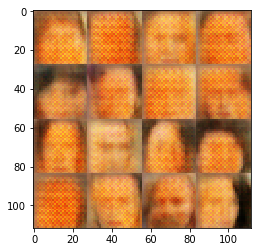

Epoch: 3/10	Step: 8520	 Discriminator Loss: 1.3987	 Generator Loss: 0.6920
Epoch: 3/10	Step: 8540	 Discriminator Loss: 1.3227	 Generator Loss: 0.8224
Epoch: 3/10	Step: 8560	 Discriminator Loss: 1.3243	 Generator Loss: 0.8702
Epoch: 3/10	Step: 8580	 Discriminator Loss: 1.4358	 Generator Loss: 0.9444
Epoch: 3/10	Step: 8600	 Discriminator Loss: 1.2509	 Generator Loss: 0.7637
Epoch: 3/10	Step: 8620	 Discriminator Loss: 0.9606	 Generator Loss: 1.4270
Epoch: 3/10	Step: 8640	 Discriminator Loss: 1.0525	 Generator Loss: 0.9978
Epoch: 3/10	Step: 8660	 Discriminator Loss: 1.0902	 Generator Loss: 0.9654
Epoch: 3/10	Step: 8680	 Discriminator Loss: 1.4262	 Generator Loss: 0.7575
Epoch: 3/10	Step: 8700	 Discriminator Loss: 1.4218	 Generator Loss: 0.6173
Epoch: 3/10	Step: 8720	 Discriminator Loss: 1.3495	 Generator Loss: 0.7229
Epoch: 3/10	Step: 8740	 Discriminator Loss: 1.3557	 Generator Loss: 0.7440
Epoch: 3/10	Step: 8760	 Discriminator Loss: 1.3817	 Generator Loss: 0.9021
Epoch: 3/10	Step: 8780	 D

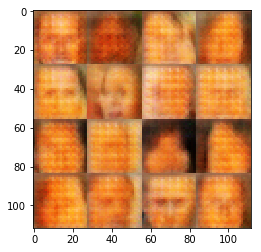

Epoch: 3/10	Step: 9020	 Discriminator Loss: 1.3951	 Generator Loss: 0.6624
Epoch: 3/10	Step: 9040	 Discriminator Loss: 1.3416	 Generator Loss: 0.7027
Epoch: 3/10	Step: 9060	 Discriminator Loss: 1.2704	 Generator Loss: 0.8227
Epoch: 3/10	Step: 9080	 Discriminator Loss: 1.3618	 Generator Loss: 0.7344
Epoch: 3/10	Step: 9100	 Discriminator Loss: 1.4100	 Generator Loss: 0.7387
Epoch: 3/10	Step: 9120	 Discriminator Loss: 1.4098	 Generator Loss: 0.7023
Epoch: 3/10	Step: 9140	 Discriminator Loss: 1.4316	 Generator Loss: 0.6019
Epoch: 3/10	Step: 9160	 Discriminator Loss: 1.3888	 Generator Loss: 0.7669
Epoch: 3/10	Step: 9180	 Discriminator Loss: 1.1864	 Generator Loss: 1.0644
Epoch: 3/10	Step: 9200	 Discriminator Loss: 1.2964	 Generator Loss: 0.7521
Epoch: 3/10	Step: 9220	 Discriminator Loss: 1.4034	 Generator Loss: 0.6788
Epoch: 3/10	Step: 9240	 Discriminator Loss: 1.5198	 Generator Loss: 0.7622
Epoch: 3/10	Step: 9260	 Discriminator Loss: 1.4242	 Generator Loss: 0.6197
Epoch: 3/10	Step: 9280	 D

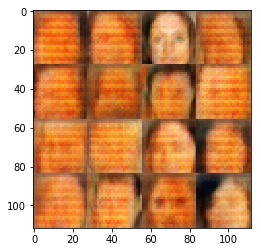

Epoch: 4/10	Step: 9520	 Discriminator Loss: 1.3819	 Generator Loss: 0.6891
Epoch: 4/10	Step: 9540	 Discriminator Loss: 1.3628	 Generator Loss: 0.7332
Epoch: 4/10	Step: 9560	 Discriminator Loss: 1.1369	 Generator Loss: 0.9253
Epoch: 4/10	Step: 9580	 Discriminator Loss: 1.1840	 Generator Loss: 1.6794
Epoch: 4/10	Step: 9600	 Discriminator Loss: 1.3613	 Generator Loss: 0.7812
Epoch: 4/10	Step: 9620	 Discriminator Loss: 1.3859	 Generator Loss: 0.7432
Epoch: 4/10	Step: 9640	 Discriminator Loss: 1.4224	 Generator Loss: 0.7259
Epoch: 4/10	Step: 9660	 Discriminator Loss: 1.3802	 Generator Loss: 0.7219
Epoch: 4/10	Step: 9680	 Discriminator Loss: 1.3129	 Generator Loss: 0.8908
Epoch: 4/10	Step: 9700	 Discriminator Loss: 1.3012	 Generator Loss: 0.8629
Epoch: 4/10	Step: 9720	 Discriminator Loss: 1.2807	 Generator Loss: 0.7319
Epoch: 4/10	Step: 9740	 Discriminator Loss: 1.4278	 Generator Loss: 0.5796
Epoch: 4/10	Step: 9760	 Discriminator Loss: 1.3796	 Generator Loss: 0.7234
Epoch: 4/10	Step: 9780	 D

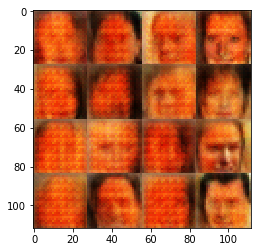

Epoch: 4/10	Step: 10020	 Discriminator Loss: 1.3877	 Generator Loss: 0.7691
Epoch: 4/10	Step: 10040	 Discriminator Loss: 1.3724	 Generator Loss: 0.7475
Epoch: 4/10	Step: 10060	 Discriminator Loss: 1.3598	 Generator Loss: 0.7730
Epoch: 4/10	Step: 10080	 Discriminator Loss: 1.4037	 Generator Loss: 0.6826
Epoch: 4/10	Step: 10100	 Discriminator Loss: 1.0962	 Generator Loss: 0.9370
Epoch: 4/10	Step: 10120	 Discriminator Loss: 1.6060	 Generator Loss: 0.3646
Epoch: 4/10	Step: 10140	 Discriminator Loss: 1.3508	 Generator Loss: 0.7527
Epoch: 4/10	Step: 10160	 Discriminator Loss: 1.3505	 Generator Loss: 0.7447
Epoch: 4/10	Step: 10180	 Discriminator Loss: 1.3621	 Generator Loss: 0.7310
Epoch: 4/10	Step: 10200	 Discriminator Loss: 1.3607	 Generator Loss: 0.8273
Epoch: 4/10	Step: 10220	 Discriminator Loss: 1.3785	 Generator Loss: 0.7719
Epoch: 4/10	Step: 10240	 Discriminator Loss: 1.3921	 Generator Loss: 0.7223
Epoch: 4/10	Step: 10260	 Discriminator Loss: 1.2601	 Generator Loss: 0.7742
Epoch: 4/10	

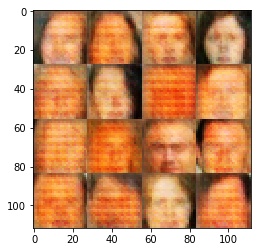

Epoch: 4/10	Step: 10520	 Discriminator Loss: 1.2976	 Generator Loss: 0.8115
Epoch: 4/10	Step: 10540	 Discriminator Loss: 1.4005	 Generator Loss: 0.7525
Epoch: 4/10	Step: 10560	 Discriminator Loss: 1.3521	 Generator Loss: 0.8157
Epoch: 4/10	Step: 10580	 Discriminator Loss: 1.1370	 Generator Loss: 0.9824
Epoch: 4/10	Step: 10600	 Discriminator Loss: 1.3662	 Generator Loss: 0.8400
Epoch: 4/10	Step: 10620	 Discriminator Loss: 1.4173	 Generator Loss: 0.7269
Epoch: 4/10	Step: 10640	 Discriminator Loss: 1.3883	 Generator Loss: 0.6633
Epoch: 4/10	Step: 10660	 Discriminator Loss: 1.3769	 Generator Loss: 0.6760
Epoch: 4/10	Step: 10680	 Discriminator Loss: 1.5047	 Generator Loss: 0.7352
Epoch: 4/10	Step: 10700	 Discriminator Loss: 1.3615	 Generator Loss: 0.7371
Epoch: 4/10	Step: 10720	 Discriminator Loss: 1.4111	 Generator Loss: 0.7927
Epoch: 4/10	Step: 10740	 Discriminator Loss: 1.3974	 Generator Loss: 0.7567
Epoch: 4/10	Step: 10760	 Discriminator Loss: 1.7628	 Generator Loss: 0.6147
Epoch: 4/10	

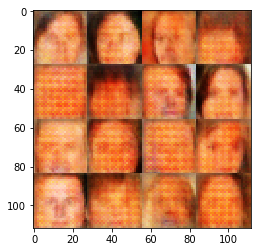

Epoch: 4/10	Step: 11020	 Discriminator Loss: 1.3760	 Generator Loss: 0.8417
Epoch: 4/10	Step: 11040	 Discriminator Loss: 1.4061	 Generator Loss: 0.6588
Epoch: 4/10	Step: 11060	 Discriminator Loss: 1.3543	 Generator Loss: 0.7194
Epoch: 4/10	Step: 11080	 Discriminator Loss: 1.3780	 Generator Loss: 0.6662
Epoch: 4/10	Step: 11100	 Discriminator Loss: 1.3496	 Generator Loss: 0.7333
Epoch: 4/10	Step: 11120	 Discriminator Loss: 1.3719	 Generator Loss: 0.6746
Epoch: 4/10	Step: 11140	 Discriminator Loss: 1.1552	 Generator Loss: 0.9925
Epoch: 4/10	Step: 11160	 Discriminator Loss: 1.7851	 Generator Loss: 1.4933
Epoch: 4/10	Step: 11180	 Discriminator Loss: 1.3684	 Generator Loss: 0.7312
Epoch: 4/10	Step: 11200	 Discriminator Loss: 1.4040	 Generator Loss: 0.6579
Epoch: 4/10	Step: 11220	 Discriminator Loss: 1.3275	 Generator Loss: 0.8135
Epoch: 4/10	Step: 11240	 Discriminator Loss: 1.2910	 Generator Loss: 0.8547
Epoch: 4/10	Step: 11260	 Discriminator Loss: 1.3177	 Generator Loss: 0.8927
Epoch: 4/10	

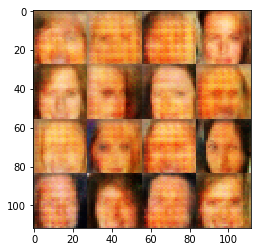

Epoch: 4/10	Step: 11520	 Discriminator Loss: 1.3502	 Generator Loss: 0.7705
Epoch: 4/10	Step: 11540	 Discriminator Loss: 1.3919	 Generator Loss: 0.6971
Epoch: 4/10	Step: 11560	 Discriminator Loss: 1.4207	 Generator Loss: 0.6005
Epoch: 4/10	Step: 11580	 Discriminator Loss: 1.4077	 Generator Loss: 0.6554
Epoch: 4/10	Step: 11600	 Discriminator Loss: 1.4073	 Generator Loss: 0.5605
Epoch: 4/10	Step: 11620	 Discriminator Loss: 1.3149	 Generator Loss: 0.7062
Epoch: 4/10	Step: 11640	 Discriminator Loss: 1.3193	 Generator Loss: 0.6452
Epoch: 4/10	Step: 11660	 Discriminator Loss: 1.3853	 Generator Loss: 0.7317
Epoch: 4/10	Step: 11680	 Discriminator Loss: 1.4089	 Generator Loss: 0.5802
Epoch: 4/10	Step: 11700	 Discriminator Loss: 1.3695	 Generator Loss: 0.7745
Epoch: 4/10	Step: 11720	 Discriminator Loss: 1.3582	 Generator Loss: 0.7330
Epoch: 4/10	Step: 11740	 Discriminator Loss: 1.3738	 Generator Loss: 0.7704
Epoch: 4/10	Step: 11760	 Discriminator Loss: 1.3798	 Generator Loss: 0.6928
Epoch: 4/10	

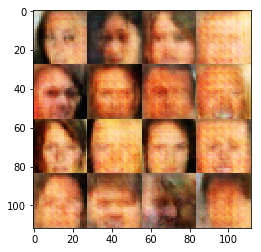

Epoch: 4/10	Step: 12020	 Discriminator Loss: 1.3131	 Generator Loss: 0.7960
Epoch: 4/10	Step: 12040	 Discriminator Loss: 1.2321	 Generator Loss: 0.7617
Epoch: 4/10	Step: 12060	 Discriminator Loss: 1.1514	 Generator Loss: 0.6904
Epoch: 4/10	Step: 12080	 Discriminator Loss: 1.4515	 Generator Loss: 0.5101
Epoch: 4/10	Step: 12100	 Discriminator Loss: 1.2912	 Generator Loss: 0.8909
Epoch: 4/10	Step: 12120	 Discriminator Loss: 1.1565	 Generator Loss: 1.0173
Epoch: 4/10	Step: 12140	 Discriminator Loss: 1.0158	 Generator Loss: 0.9648
Epoch: 4/10	Step: 12160	 Discriminator Loss: 1.2986	 Generator Loss: 1.1151
Epoch: 4/10	Step: 12180	 Discriminator Loss: 1.3821	 Generator Loss: 0.8178
Epoch: 4/10	Step: 12200	 Discriminator Loss: 1.3700	 Generator Loss: 0.7749
Epoch: 4/10	Step: 12220	 Discriminator Loss: 1.4271	 Generator Loss: 0.7367
Epoch: 4/10	Step: 12240	 Discriminator Loss: 1.2058	 Generator Loss: 0.9147
Epoch: 4/10	Step: 12260	 Discriminator Loss: 1.3529	 Generator Loss: 0.9166
Epoch: 4/10	

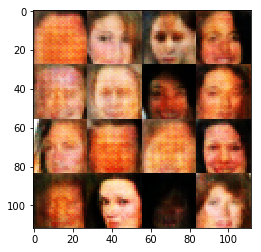

Epoch: 4/10	Step: 12520	 Discriminator Loss: 1.4216	 Generator Loss: 0.6489
Epoch: 4/10	Step: 12540	 Discriminator Loss: 1.2957	 Generator Loss: 0.7615
Epoch: 4/10	Step: 12560	 Discriminator Loss: 1.3135	 Generator Loss: 0.8246
Epoch: 4/10	Step: 12580	 Discriminator Loss: 1.5678	 Generator Loss: 0.4159
Epoch: 4/10	Step: 12600	 Discriminator Loss: 1.3388	 Generator Loss: 0.7180
Epoch: 4/10	Step: 12620	 Discriminator Loss: 1.4059	 Generator Loss: 0.6647
Epoch: 4/10	Step: 12640	 Discriminator Loss: 1.3345	 Generator Loss: 0.8495
Epoch: 4/10	Step: 12660	 Discriminator Loss: 1.3639	 Generator Loss: 0.7301
Epoch: 5/10	Step: 12680	 Discriminator Loss: 1.2757	 Generator Loss: 0.8194
Epoch: 5/10	Step: 12700	 Discriminator Loss: 1.4271	 Generator Loss: 0.5698
Epoch: 5/10	Step: 12720	 Discriminator Loss: 1.3273	 Generator Loss: 0.7803
Epoch: 5/10	Step: 12740	 Discriminator Loss: 0.9320	 Generator Loss: 1.3157
Epoch: 5/10	Step: 12760	 Discriminator Loss: 1.0221	 Generator Loss: 0.8205
Epoch: 5/10	

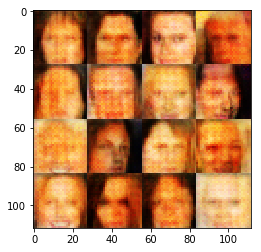

Epoch: 5/10	Step: 13020	 Discriminator Loss: 1.3425	 Generator Loss: 0.7119
Epoch: 5/10	Step: 13040	 Discriminator Loss: 1.0567	 Generator Loss: 1.5464
Epoch: 5/10	Step: 13060	 Discriminator Loss: 1.4207	 Generator Loss: 0.6826
Epoch: 5/10	Step: 13080	 Discriminator Loss: 1.4228	 Generator Loss: 0.7506
Epoch: 5/10	Step: 13100	 Discriminator Loss: 1.4008	 Generator Loss: 0.6567
Epoch: 5/10	Step: 13120	 Discriminator Loss: 1.3823	 Generator Loss: 0.7088
Epoch: 5/10	Step: 13140	 Discriminator Loss: 1.2884	 Generator Loss: 0.7911
Epoch: 5/10	Step: 13160	 Discriminator Loss: 1.3883	 Generator Loss: 0.6888
Epoch: 5/10	Step: 13180	 Discriminator Loss: 1.2656	 Generator Loss: 0.9008
Epoch: 5/10	Step: 13200	 Discriminator Loss: 1.3590	 Generator Loss: 0.7930
Epoch: 5/10	Step: 13220	 Discriminator Loss: 1.4044	 Generator Loss: 0.7062
Epoch: 5/10	Step: 13240	 Discriminator Loss: 1.3604	 Generator Loss: 0.6723
Epoch: 5/10	Step: 13260	 Discriminator Loss: 1.3822	 Generator Loss: 0.6294
Epoch: 5/10	

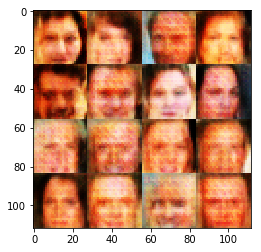

Epoch: 5/10	Step: 13520	 Discriminator Loss: 1.7287	 Generator Loss: 0.5512
Epoch: 5/10	Step: 13540	 Discriminator Loss: 0.8124	 Generator Loss: 1.7226
Epoch: 5/10	Step: 13560	 Discriminator Loss: 1.3079	 Generator Loss: 0.7385
Epoch: 5/10	Step: 13580	 Discriminator Loss: 1.4630	 Generator Loss: 0.5919
Epoch: 5/10	Step: 13600	 Discriminator Loss: 1.3740	 Generator Loss: 0.7862
Epoch: 5/10	Step: 13620	 Discriminator Loss: 1.3128	 Generator Loss: 0.7463
Epoch: 5/10	Step: 13640	 Discriminator Loss: 1.4684	 Generator Loss: 0.5577
Epoch: 5/10	Step: 13660	 Discriminator Loss: 1.3438	 Generator Loss: 0.7674
Epoch: 5/10	Step: 13680	 Discriminator Loss: 1.3343	 Generator Loss: 0.6563
Epoch: 5/10	Step: 13700	 Discriminator Loss: 1.2172	 Generator Loss: 1.2016
Epoch: 5/10	Step: 13720	 Discriminator Loss: 1.4528	 Generator Loss: 0.4845
Epoch: 5/10	Step: 13740	 Discriminator Loss: 0.9647	 Generator Loss: 1.1083
Epoch: 5/10	Step: 13760	 Discriminator Loss: 0.6508	 Generator Loss: 1.6981
Epoch: 5/10	

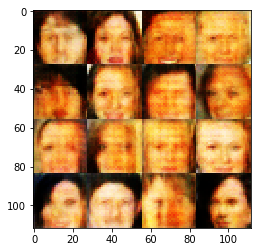

Epoch: 5/10	Step: 14020	 Discriminator Loss: 1.2654	 Generator Loss: 0.8688
Epoch: 5/10	Step: 14040	 Discriminator Loss: 1.0779	 Generator Loss: 1.7401
Epoch: 5/10	Step: 14060	 Discriminator Loss: 1.3611	 Generator Loss: 0.7123
Epoch: 5/10	Step: 14080	 Discriminator Loss: 1.3668	 Generator Loss: 0.6916
Epoch: 5/10	Step: 14100	 Discriminator Loss: 1.3687	 Generator Loss: 0.6912
Epoch: 5/10	Step: 14120	 Discriminator Loss: 1.3216	 Generator Loss: 0.8281
Epoch: 5/10	Step: 14140	 Discriminator Loss: 1.0561	 Generator Loss: 2.1752
Epoch: 5/10	Step: 14160	 Discriminator Loss: 1.3645	 Generator Loss: 0.7343
Epoch: 5/10	Step: 14180	 Discriminator Loss: 1.3164	 Generator Loss: 0.8813
Epoch: 5/10	Step: 14200	 Discriminator Loss: 1.3341	 Generator Loss: 0.8093
Epoch: 5/10	Step: 14220	 Discriminator Loss: 1.3328	 Generator Loss: 0.7089
Epoch: 5/10	Step: 14240	 Discriminator Loss: 1.3295	 Generator Loss: 0.7414
Epoch: 5/10	Step: 14260	 Discriminator Loss: 1.3646	 Generator Loss: 0.7350
Epoch: 5/10	

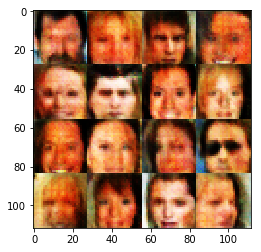

Epoch: 5/10	Step: 14520	 Discriminator Loss: 1.1384	 Generator Loss: 0.8348
Epoch: 5/10	Step: 14540	 Discriminator Loss: 1.4087	 Generator Loss: 0.6187
Epoch: 5/10	Step: 14560	 Discriminator Loss: 1.3602	 Generator Loss: 0.7011
Epoch: 5/10	Step: 14580	 Discriminator Loss: 1.3524	 Generator Loss: 0.7102
Epoch: 5/10	Step: 14600	 Discriminator Loss: 1.3695	 Generator Loss: 0.6053
Epoch: 5/10	Step: 14620	 Discriminator Loss: 1.2294	 Generator Loss: 0.9589
Epoch: 5/10	Step: 14640	 Discriminator Loss: 1.3003	 Generator Loss: 0.5953
Epoch: 5/10	Step: 14660	 Discriminator Loss: 1.3195	 Generator Loss: 0.6990
Epoch: 5/10	Step: 14680	 Discriminator Loss: 1.3316	 Generator Loss: 0.7885
Epoch: 5/10	Step: 14700	 Discriminator Loss: 1.3154	 Generator Loss: 0.6427
Epoch: 5/10	Step: 14720	 Discriminator Loss: 1.3323	 Generator Loss: 0.6636
Epoch: 5/10	Step: 14740	 Discriminator Loss: 1.2240	 Generator Loss: 0.7025
Epoch: 5/10	Step: 14760	 Discriminator Loss: 1.3150	 Generator Loss: 0.5787
Epoch: 5/10	

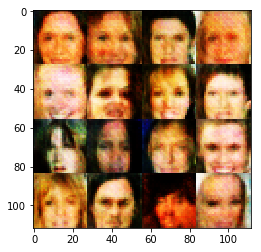

Epoch: 5/10	Step: 15020	 Discriminator Loss: 1.3519	 Generator Loss: 0.7813
Epoch: 5/10	Step: 15040	 Discriminator Loss: 1.3067	 Generator Loss: 0.7297
Epoch: 5/10	Step: 15060	 Discriminator Loss: 1.3071	 Generator Loss: 0.7783
Epoch: 5/10	Step: 15080	 Discriminator Loss: 1.3673	 Generator Loss: 0.5789
Epoch: 5/10	Step: 15100	 Discriminator Loss: 1.0746	 Generator Loss: 0.9455
Epoch: 5/10	Step: 15120	 Discriminator Loss: 1.3430	 Generator Loss: 0.9298
Epoch: 5/10	Step: 15140	 Discriminator Loss: 1.2765	 Generator Loss: 0.7923
Epoch: 5/10	Step: 15160	 Discriminator Loss: 1.2023	 Generator Loss: 0.8502
Epoch: 5/10	Step: 15180	 Discriminator Loss: 1.3829	 Generator Loss: 0.6982
Epoch: 5/10	Step: 15200	 Discriminator Loss: 1.3448	 Generator Loss: 0.7034
Epoch: 5/10	Step: 15220	 Discriminator Loss: 1.3301	 Generator Loss: 0.8586
Epoch: 5/10	Step: 15240	 Discriminator Loss: 1.6378	 Generator Loss: 1.3150
Epoch: 5/10	Step: 15260	 Discriminator Loss: 1.4263	 Generator Loss: 0.9066
Epoch: 5/10	

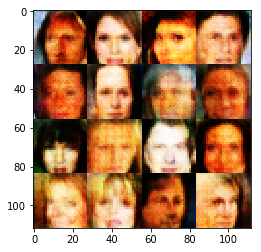

Epoch: 5/10	Step: 15520	 Discriminator Loss: 1.1145	 Generator Loss: 1.0759
Epoch: 5/10	Step: 15540	 Discriminator Loss: 1.6227	 Generator Loss: 0.4629
Epoch: 5/10	Step: 15560	 Discriminator Loss: 1.4209	 Generator Loss: 0.5762
Epoch: 5/10	Step: 15580	 Discriminator Loss: 1.1553	 Generator Loss: 0.9199
Epoch: 5/10	Step: 15600	 Discriminator Loss: 1.6687	 Generator Loss: 0.9518
Epoch: 5/10	Step: 15620	 Discriminator Loss: 1.2914	 Generator Loss: 0.7471
Epoch: 5/10	Step: 15640	 Discriminator Loss: 1.0654	 Generator Loss: 1.0698
Epoch: 5/10	Step: 15660	 Discriminator Loss: 1.4152	 Generator Loss: 0.5725
Epoch: 5/10	Step: 15680	 Discriminator Loss: 1.3431	 Generator Loss: 0.6680
Epoch: 5/10	Step: 15700	 Discriminator Loss: 1.2762	 Generator Loss: 0.7736
Epoch: 5/10	Step: 15720	 Discriminator Loss: 1.3769	 Generator Loss: 0.7137
Epoch: 5/10	Step: 15740	 Discriminator Loss: 1.3169	 Generator Loss: 0.8100
Epoch: 5/10	Step: 15760	 Discriminator Loss: 0.9171	 Generator Loss: 1.1897
Epoch: 5/10	

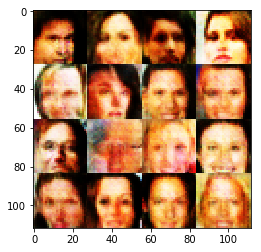

Epoch: 6/10	Step: 16020	 Discriminator Loss: 1.2400	 Generator Loss: 0.9562
Epoch: 6/10	Step: 16040	 Discriminator Loss: 1.2393	 Generator Loss: 1.1225
Epoch: 6/10	Step: 16060	 Discriminator Loss: 1.3928	 Generator Loss: 0.6171
Epoch: 6/10	Step: 16080	 Discriminator Loss: 1.3112	 Generator Loss: 0.6025
Epoch: 6/10	Step: 16100	 Discriminator Loss: 1.2777	 Generator Loss: 0.7548
Epoch: 6/10	Step: 16120	 Discriminator Loss: 1.2818	 Generator Loss: 0.7516
Epoch: 6/10	Step: 16140	 Discriminator Loss: 1.1659	 Generator Loss: 0.8890
Epoch: 6/10	Step: 16160	 Discriminator Loss: 1.2655	 Generator Loss: 0.7525
Epoch: 6/10	Step: 16180	 Discriminator Loss: 1.1188	 Generator Loss: 1.2484
Epoch: 6/10	Step: 16200	 Discriminator Loss: 1.1372	 Generator Loss: 0.8254
Epoch: 6/10	Step: 16220	 Discriminator Loss: 1.2258	 Generator Loss: 0.8945
Epoch: 6/10	Step: 16240	 Discriminator Loss: 1.0149	 Generator Loss: 1.1024
Epoch: 6/10	Step: 16260	 Discriminator Loss: 1.1713	 Generator Loss: 0.8929
Epoch: 6/10	

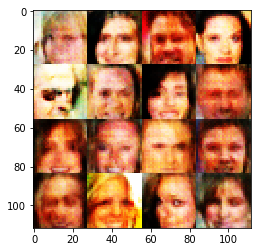

Epoch: 6/10	Step: 16520	 Discriminator Loss: 1.3595	 Generator Loss: 0.7977
Epoch: 6/10	Step: 16540	 Discriminator Loss: 1.0380	 Generator Loss: 0.9446
Epoch: 6/10	Step: 16560	 Discriminator Loss: 0.9248	 Generator Loss: 1.5387
Epoch: 6/10	Step: 16580	 Discriminator Loss: 1.2749	 Generator Loss: 0.7361
Epoch: 6/10	Step: 16600	 Discriminator Loss: 1.2397	 Generator Loss: 0.7889
Epoch: 6/10	Step: 16620	 Discriminator Loss: 1.4629	 Generator Loss: 0.6603
Epoch: 6/10	Step: 16640	 Discriminator Loss: 1.3767	 Generator Loss: 0.7359
Epoch: 6/10	Step: 16660	 Discriminator Loss: 1.1906	 Generator Loss: 0.7545
Epoch: 6/10	Step: 16680	 Discriminator Loss: 1.2859	 Generator Loss: 0.7448
Epoch: 6/10	Step: 16700	 Discriminator Loss: 1.3225	 Generator Loss: 0.7037
Epoch: 6/10	Step: 16720	 Discriminator Loss: 0.9210	 Generator Loss: 1.2123
Epoch: 6/10	Step: 16740	 Discriminator Loss: 1.2914	 Generator Loss: 0.8296
Epoch: 6/10	Step: 16760	 Discriminator Loss: 1.2371	 Generator Loss: 0.8353
Epoch: 6/10	

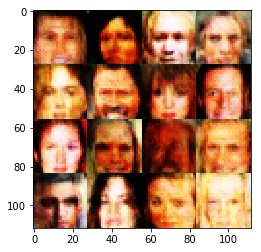

Epoch: 6/10	Step: 17020	 Discriminator Loss: 1.2793	 Generator Loss: 0.7549
Epoch: 6/10	Step: 17040	 Discriminator Loss: 1.5112	 Generator Loss: 0.4741
Epoch: 6/10	Step: 17060	 Discriminator Loss: 0.9532	 Generator Loss: 1.6155
Epoch: 6/10	Step: 17080	 Discriminator Loss: 1.0540	 Generator Loss: 1.2185
Epoch: 6/10	Step: 17100	 Discriminator Loss: 1.4164	 Generator Loss: 0.7045
Epoch: 6/10	Step: 17120	 Discriminator Loss: 1.4206	 Generator Loss: 0.6832
Epoch: 6/10	Step: 17140	 Discriminator Loss: 1.1815	 Generator Loss: 0.7173
Epoch: 6/10	Step: 17160	 Discriminator Loss: 1.2427	 Generator Loss: 0.6439
Epoch: 6/10	Step: 17180	 Discriminator Loss: 1.0646	 Generator Loss: 1.4321
Epoch: 6/10	Step: 17200	 Discriminator Loss: 1.3037	 Generator Loss: 1.3368
Epoch: 6/10	Step: 17220	 Discriminator Loss: 1.2999	 Generator Loss: 0.7669
Epoch: 6/10	Step: 17240	 Discriminator Loss: 1.3571	 Generator Loss: 0.6099
Epoch: 6/10	Step: 17260	 Discriminator Loss: 1.2251	 Generator Loss: 0.8028
Epoch: 6/10	

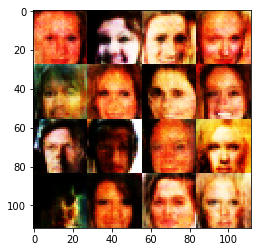

Epoch: 6/10	Step: 17520	 Discriminator Loss: 1.1848	 Generator Loss: 0.9541
Epoch: 6/10	Step: 17540	 Discriminator Loss: 1.3306	 Generator Loss: 0.6196
Epoch: 6/10	Step: 17560	 Discriminator Loss: 1.2474	 Generator Loss: 0.7908
Epoch: 6/10	Step: 17580	 Discriminator Loss: 1.4243	 Generator Loss: 1.5725
Epoch: 6/10	Step: 17600	 Discriminator Loss: 1.3496	 Generator Loss: 0.6581
Epoch: 6/10	Step: 17620	 Discriminator Loss: 1.2873	 Generator Loss: 0.7416
Epoch: 6/10	Step: 17640	 Discriminator Loss: 1.6984	 Generator Loss: 0.3906
Epoch: 6/10	Step: 17660	 Discriminator Loss: 1.3058	 Generator Loss: 0.7636
Epoch: 6/10	Step: 17680	 Discriminator Loss: 1.3331	 Generator Loss: 0.8173
Epoch: 6/10	Step: 17700	 Discriminator Loss: 1.2546	 Generator Loss: 0.7893
Epoch: 6/10	Step: 17720	 Discriminator Loss: 1.3300	 Generator Loss: 0.8772
Epoch: 6/10	Step: 17740	 Discriminator Loss: 1.3602	 Generator Loss: 0.6921
Epoch: 6/10	Step: 17760	 Discriminator Loss: 1.0559	 Generator Loss: 1.0678
Epoch: 6/10	

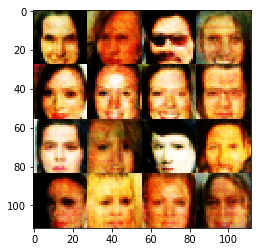

Epoch: 6/10	Step: 18020	 Discriminator Loss: 1.2030	 Generator Loss: 1.0644
Epoch: 6/10	Step: 18040	 Discriminator Loss: 1.3585	 Generator Loss: 0.7648
Epoch: 6/10	Step: 18060	 Discriminator Loss: 1.2532	 Generator Loss: 0.7578
Epoch: 6/10	Step: 18080	 Discriminator Loss: 1.3354	 Generator Loss: 0.7646
Epoch: 6/10	Step: 18100	 Discriminator Loss: 1.2878	 Generator Loss: 0.6165
Epoch: 6/10	Step: 18120	 Discriminator Loss: 1.4108	 Generator Loss: 0.6132
Epoch: 6/10	Step: 18140	 Discriminator Loss: 1.2521	 Generator Loss: 0.9664
Epoch: 6/10	Step: 18160	 Discriminator Loss: 1.2237	 Generator Loss: 0.8624
Epoch: 6/10	Step: 18180	 Discriminator Loss: 1.0681	 Generator Loss: 2.3342
Epoch: 6/10	Step: 18200	 Discriminator Loss: 1.2905	 Generator Loss: 0.9419
Epoch: 6/10	Step: 18220	 Discriminator Loss: 1.3734	 Generator Loss: 0.8858
Epoch: 6/10	Step: 18240	 Discriminator Loss: 1.2524	 Generator Loss: 0.8478
Epoch: 6/10	Step: 18260	 Discriminator Loss: 1.4235	 Generator Loss: 0.7252
Epoch: 6/10	

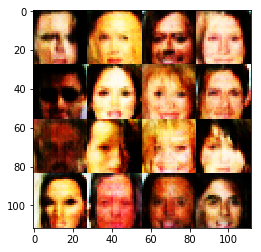

Epoch: 6/10	Step: 18520	 Discriminator Loss: 1.1845	 Generator Loss: 0.6870
Epoch: 6/10	Step: 18540	 Discriminator Loss: 1.2253	 Generator Loss: 1.0340
Epoch: 6/10	Step: 18560	 Discriminator Loss: 1.2102	 Generator Loss: 0.9174
Epoch: 6/10	Step: 18580	 Discriminator Loss: 1.4656	 Generator Loss: 0.4980
Epoch: 6/10	Step: 18600	 Discriminator Loss: 1.5626	 Generator Loss: 1.6465
Epoch: 6/10	Step: 18620	 Discriminator Loss: 1.2608	 Generator Loss: 0.8469
Epoch: 6/10	Step: 18640	 Discriminator Loss: 1.3552	 Generator Loss: 0.7757
Epoch: 6/10	Step: 18660	 Discriminator Loss: 1.2689	 Generator Loss: 0.8187
Epoch: 6/10	Step: 18680	 Discriminator Loss: 1.6088	 Generator Loss: 1.2288
Epoch: 6/10	Step: 18700	 Discriminator Loss: 1.3548	 Generator Loss: 0.7314
Epoch: 6/10	Step: 18720	 Discriminator Loss: 1.2871	 Generator Loss: 0.7714
Epoch: 6/10	Step: 18740	 Discriminator Loss: 1.1098	 Generator Loss: 0.9765
Epoch: 6/10	Step: 18760	 Discriminator Loss: 1.1426	 Generator Loss: 1.0873
Epoch: 6/10	

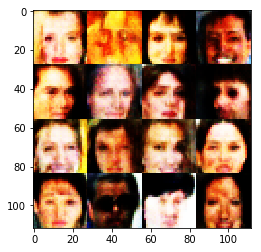

Epoch: 7/10	Step: 19020	 Discriminator Loss: 1.3053	 Generator Loss: 0.7838
Epoch: 7/10	Step: 19040	 Discriminator Loss: 1.2955	 Generator Loss: 0.7654
Epoch: 7/10	Step: 19060	 Discriminator Loss: 0.9732	 Generator Loss: 1.2978
Epoch: 7/10	Step: 19080	 Discriminator Loss: 1.3588	 Generator Loss: 0.5802
Epoch: 7/10	Step: 19100	 Discriminator Loss: 1.0996	 Generator Loss: 0.9370
Epoch: 7/10	Step: 19120	 Discriminator Loss: 1.1425	 Generator Loss: 0.8226
Epoch: 7/10	Step: 19140	 Discriminator Loss: 1.1129	 Generator Loss: 1.1226
Epoch: 7/10	Step: 19160	 Discriminator Loss: 1.2739	 Generator Loss: 1.2183
Epoch: 7/10	Step: 19180	 Discriminator Loss: 1.4270	 Generator Loss: 0.5623
Epoch: 7/10	Step: 19200	 Discriminator Loss: 1.3186	 Generator Loss: 0.7420
Epoch: 7/10	Step: 19220	 Discriminator Loss: 1.3810	 Generator Loss: 0.9310
Epoch: 7/10	Step: 19240	 Discriminator Loss: 1.1315	 Generator Loss: 0.9295
Epoch: 7/10	Step: 19260	 Discriminator Loss: 1.3076	 Generator Loss: 0.7169
Epoch: 7/10	

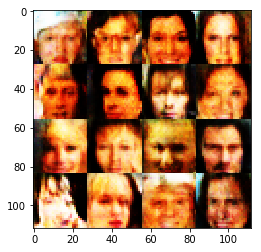

Epoch: 7/10	Step: 19520	 Discriminator Loss: 1.3430	 Generator Loss: 0.6500
Epoch: 7/10	Step: 19540	 Discriminator Loss: 1.2824	 Generator Loss: 0.7317
Epoch: 7/10	Step: 19560	 Discriminator Loss: 1.1425	 Generator Loss: 0.9725
Epoch: 7/10	Step: 19580	 Discriminator Loss: 1.3580	 Generator Loss: 0.6391
Epoch: 7/10	Step: 19600	 Discriminator Loss: 1.3674	 Generator Loss: 0.5655
Epoch: 7/10	Step: 19620	 Discriminator Loss: 1.3227	 Generator Loss: 0.7507
Epoch: 7/10	Step: 19640	 Discriminator Loss: 1.4455	 Generator Loss: 1.1584
Epoch: 7/10	Step: 19660	 Discriminator Loss: 2.0420	 Generator Loss: 0.2284
Epoch: 7/10	Step: 19680	 Discriminator Loss: 1.3415	 Generator Loss: 0.6742
Epoch: 7/10	Step: 19700	 Discriminator Loss: 1.3577	 Generator Loss: 0.6959
Epoch: 7/10	Step: 19720	 Discriminator Loss: 1.2482	 Generator Loss: 0.9702
Epoch: 7/10	Step: 19740	 Discriminator Loss: 1.2551	 Generator Loss: 1.2574
Epoch: 7/10	Step: 19760	 Discriminator Loss: 1.3011	 Generator Loss: 0.7464
Epoch: 7/10	

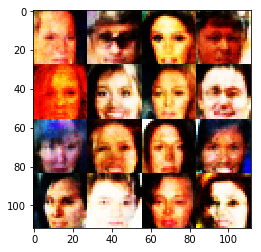

Epoch: 7/10	Step: 20020	 Discriminator Loss: 1.2232	 Generator Loss: 0.7702
Epoch: 7/10	Step: 20040	 Discriminator Loss: 1.4540	 Generator Loss: 1.2100
Epoch: 7/10	Step: 20060	 Discriminator Loss: 1.4196	 Generator Loss: 0.6115
Epoch: 7/10	Step: 20080	 Discriminator Loss: 1.3701	 Generator Loss: 0.7649
Epoch: 7/10	Step: 20100	 Discriminator Loss: 1.4589	 Generator Loss: 0.5561
Epoch: 7/10	Step: 20120	 Discriminator Loss: 1.3515	 Generator Loss: 0.7195
Epoch: 7/10	Step: 20140	 Discriminator Loss: 1.0195	 Generator Loss: 1.4910
Epoch: 7/10	Step: 20160	 Discriminator Loss: 1.3351	 Generator Loss: 0.8800
Epoch: 7/10	Step: 20180	 Discriminator Loss: 1.2884	 Generator Loss: 0.8726
Epoch: 7/10	Step: 20200	 Discriminator Loss: 1.2697	 Generator Loss: 0.6340
Epoch: 7/10	Step: 20220	 Discriminator Loss: 1.0896	 Generator Loss: 1.2661
Epoch: 7/10	Step: 20240	 Discriminator Loss: 1.5621	 Generator Loss: 0.7680
Epoch: 7/10	Step: 20260	 Discriminator Loss: 1.3664	 Generator Loss: 0.8178
Epoch: 7/10	

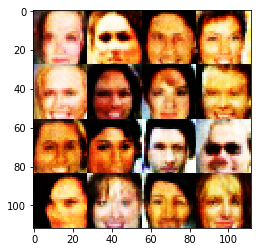

Epoch: 7/10	Step: 20520	 Discriminator Loss: 1.3324	 Generator Loss: 0.6949
Epoch: 7/10	Step: 20540	 Discriminator Loss: 1.3854	 Generator Loss: 1.0183
Epoch: 7/10	Step: 20560	 Discriminator Loss: 1.3045	 Generator Loss: 0.9221
Epoch: 7/10	Step: 20580	 Discriminator Loss: 1.0694	 Generator Loss: 1.2049
Epoch: 7/10	Step: 20600	 Discriminator Loss: 1.2191	 Generator Loss: 0.6884
Epoch: 7/10	Step: 20620	 Discriminator Loss: 1.4534	 Generator Loss: 1.7571
Epoch: 7/10	Step: 20640	 Discriminator Loss: 1.3526	 Generator Loss: 0.6053
Epoch: 7/10	Step: 20660	 Discriminator Loss: 1.1225	 Generator Loss: 0.8943
Epoch: 7/10	Step: 20680	 Discriminator Loss: 1.2255	 Generator Loss: 0.7321
Epoch: 7/10	Step: 20700	 Discriminator Loss: 1.3579	 Generator Loss: 0.5466
Epoch: 7/10	Step: 20720	 Discriminator Loss: 1.3362	 Generator Loss: 0.9103
Epoch: 7/10	Step: 20740	 Discriminator Loss: 1.4406	 Generator Loss: 0.5227
Epoch: 7/10	Step: 20760	 Discriminator Loss: 1.4850	 Generator Loss: 1.1386
Epoch: 7/10	

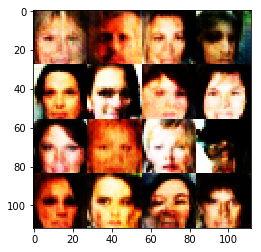

Epoch: 7/10	Step: 21020	 Discriminator Loss: 1.3487	 Generator Loss: 0.6605
Epoch: 7/10	Step: 21040	 Discriminator Loss: 1.2667	 Generator Loss: 0.9157
Epoch: 7/10	Step: 21060	 Discriminator Loss: 1.3642	 Generator Loss: 0.5350
Epoch: 7/10	Step: 21080	 Discriminator Loss: 1.2916	 Generator Loss: 0.8851
Epoch: 7/10	Step: 21100	 Discriminator Loss: 1.2634	 Generator Loss: 0.7450
Epoch: 7/10	Step: 21120	 Discriminator Loss: 1.0284	 Generator Loss: 1.4284
Epoch: 7/10	Step: 21140	 Discriminator Loss: 1.3528	 Generator Loss: 0.6357
Epoch: 7/10	Step: 21160	 Discriminator Loss: 0.8173	 Generator Loss: 1.4209
Epoch: 7/10	Step: 21180	 Discriminator Loss: 1.3561	 Generator Loss: 0.7305
Epoch: 7/10	Step: 21200	 Discriminator Loss: 1.2469	 Generator Loss: 0.6555
Epoch: 7/10	Step: 21220	 Discriminator Loss: 1.3789	 Generator Loss: 0.6505
Epoch: 7/10	Step: 21240	 Discriminator Loss: 1.3015	 Generator Loss: 0.8045
Epoch: 7/10	Step: 21260	 Discriminator Loss: 1.0769	 Generator Loss: 1.1437
Epoch: 7/10	

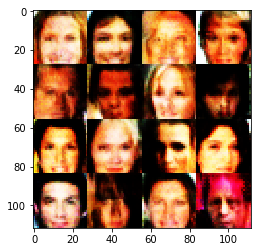

Epoch: 7/10	Step: 21520	 Discriminator Loss: 0.7602	 Generator Loss: 1.6557
Epoch: 7/10	Step: 21540	 Discriminator Loss: 1.3199	 Generator Loss: 0.7641
Epoch: 7/10	Step: 21560	 Discriminator Loss: 1.1427	 Generator Loss: 1.3364
Epoch: 7/10	Step: 21580	 Discriminator Loss: 1.3555	 Generator Loss: 0.6379
Epoch: 7/10	Step: 21600	 Discriminator Loss: 1.3696	 Generator Loss: 0.6559
Epoch: 7/10	Step: 21620	 Discriminator Loss: 1.3941	 Generator Loss: 0.5165
Epoch: 7/10	Step: 21640	 Discriminator Loss: 1.3030	 Generator Loss: 0.7248
Epoch: 7/10	Step: 21660	 Discriminator Loss: 1.3133	 Generator Loss: 0.5917
Epoch: 7/10	Step: 21680	 Discriminator Loss: 1.0185	 Generator Loss: 1.4934
Epoch: 7/10	Step: 21700	 Discriminator Loss: 1.4312	 Generator Loss: 0.4721
Epoch: 7/10	Step: 21720	 Discriminator Loss: 1.2795	 Generator Loss: 0.8756
Epoch: 7/10	Step: 21740	 Discriminator Loss: 1.4126	 Generator Loss: 0.5589
Epoch: 7/10	Step: 21760	 Discriminator Loss: 1.2033	 Generator Loss: 0.8212
Epoch: 7/10	

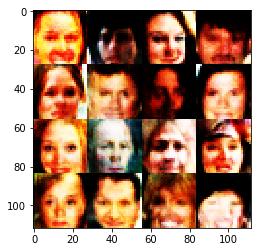

Epoch: 7/10	Step: 22020	 Discriminator Loss: 1.3121	 Generator Loss: 0.6341
Epoch: 7/10	Step: 22040	 Discriminator Loss: 1.3404	 Generator Loss: 0.7056
Epoch: 7/10	Step: 22060	 Discriminator Loss: 1.2230	 Generator Loss: 0.7980
Epoch: 7/10	Step: 22080	 Discriminator Loss: 1.2272	 Generator Loss: 0.7216
Epoch: 7/10	Step: 22100	 Discriminator Loss: 0.9169	 Generator Loss: 1.1216
Epoch: 7/10	Step: 22120	 Discriminator Loss: 1.2368	 Generator Loss: 0.7954
Epoch: 7/10	Step: 22140	 Discriminator Loss: 1.3143	 Generator Loss: 0.7979
Epoch: 8/10	Step: 22160	 Discriminator Loss: 1.1968	 Generator Loss: 0.8654
Epoch: 8/10	Step: 22180	 Discriminator Loss: 1.3808	 Generator Loss: 1.1671
Epoch: 8/10	Step: 22200	 Discriminator Loss: 1.2928	 Generator Loss: 0.8113
Epoch: 8/10	Step: 22220	 Discriminator Loss: 1.3407	 Generator Loss: 0.5891
Epoch: 8/10	Step: 22240	 Discriminator Loss: 1.3057	 Generator Loss: 0.7669
Epoch: 8/10	Step: 22260	 Discriminator Loss: 1.2335	 Generator Loss: 0.9741
Epoch: 8/10	

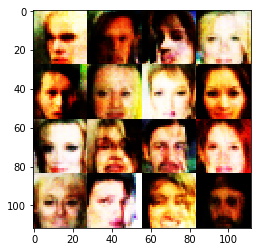

Epoch: 8/10	Step: 22520	 Discriminator Loss: 1.3386	 Generator Loss: 0.7798
Epoch: 8/10	Step: 22540	 Discriminator Loss: 1.3108	 Generator Loss: 1.0121
Epoch: 8/10	Step: 22560	 Discriminator Loss: 1.3730	 Generator Loss: 0.7146
Epoch: 8/10	Step: 22580	 Discriminator Loss: 1.1076	 Generator Loss: 0.7444
Epoch: 8/10	Step: 22600	 Discriminator Loss: 1.0334	 Generator Loss: 1.5282
Epoch: 8/10	Step: 22620	 Discriminator Loss: 1.0145	 Generator Loss: 1.2809
Epoch: 8/10	Step: 22640	 Discriminator Loss: 1.4448	 Generator Loss: 0.5037
Epoch: 8/10	Step: 22660	 Discriminator Loss: 1.3480	 Generator Loss: 0.6950
Epoch: 8/10	Step: 22680	 Discriminator Loss: 1.3916	 Generator Loss: 0.5644
Epoch: 8/10	Step: 22700	 Discriminator Loss: 0.9527	 Generator Loss: 1.1441
Epoch: 8/10	Step: 22720	 Discriminator Loss: 1.1243	 Generator Loss: 1.0055
Epoch: 8/10	Step: 22740	 Discriminator Loss: 1.4430	 Generator Loss: 0.6144
Epoch: 8/10	Step: 22760	 Discriminator Loss: 1.2000	 Generator Loss: 0.7567
Epoch: 8/10	

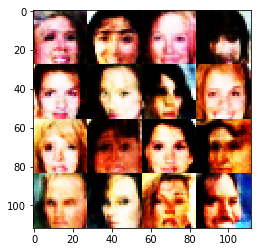

Epoch: 8/10	Step: 23020	 Discriminator Loss: 1.1030	 Generator Loss: 0.9817
Epoch: 8/10	Step: 23040	 Discriminator Loss: 1.4027	 Generator Loss: 1.1206
Epoch: 8/10	Step: 23060	 Discriminator Loss: 1.1931	 Generator Loss: 0.9021
Epoch: 8/10	Step: 23080	 Discriminator Loss: 1.3047	 Generator Loss: 0.7325
Epoch: 8/10	Step: 23100	 Discriminator Loss: 1.0820	 Generator Loss: 2.2964
Epoch: 8/10	Step: 23120	 Discriminator Loss: 1.1348	 Generator Loss: 1.2906
Epoch: 8/10	Step: 23140	 Discriminator Loss: 0.9113	 Generator Loss: 1.0520
Epoch: 8/10	Step: 23160	 Discriminator Loss: 1.2617	 Generator Loss: 0.7789
Epoch: 8/10	Step: 23180	 Discriminator Loss: 1.0994	 Generator Loss: 1.3954
Epoch: 8/10	Step: 23200	 Discriminator Loss: 1.4284	 Generator Loss: 0.5247
Epoch: 8/10	Step: 23220	 Discriminator Loss: 1.3001	 Generator Loss: 0.6777
Epoch: 8/10	Step: 23240	 Discriminator Loss: 1.2590	 Generator Loss: 1.1194
Epoch: 8/10	Step: 23260	 Discriminator Loss: 1.1456	 Generator Loss: 1.8666
Epoch: 8/10	

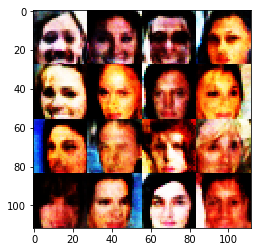

Epoch: 8/10	Step: 23520	 Discriminator Loss: 1.2773	 Generator Loss: 0.8874
Epoch: 8/10	Step: 23540	 Discriminator Loss: 1.3076	 Generator Loss: 0.7120
Epoch: 8/10	Step: 23560	 Discriminator Loss: 1.3562	 Generator Loss: 0.5785
Epoch: 8/10	Step: 23580	 Discriminator Loss: 1.5813	 Generator Loss: 0.4364
Epoch: 8/10	Step: 23600	 Discriminator Loss: 1.3352	 Generator Loss: 0.6056
Epoch: 8/10	Step: 23620	 Discriminator Loss: 1.0142	 Generator Loss: 1.0727
Epoch: 8/10	Step: 23640	 Discriminator Loss: 1.3247	 Generator Loss: 0.7280
Epoch: 8/10	Step: 23660	 Discriminator Loss: 1.1272	 Generator Loss: 0.7772
Epoch: 8/10	Step: 23680	 Discriminator Loss: 0.8899	 Generator Loss: 2.0420
Epoch: 8/10	Step: 23700	 Discriminator Loss: 1.3101	 Generator Loss: 0.9290
Epoch: 8/10	Step: 23720	 Discriminator Loss: 0.8740	 Generator Loss: 1.5768
Epoch: 8/10	Step: 23740	 Discriminator Loss: 1.3399	 Generator Loss: 0.7619
Epoch: 8/10	Step: 23760	 Discriminator Loss: 1.3420	 Generator Loss: 0.6845
Epoch: 8/10	

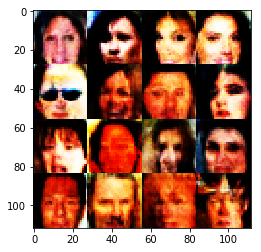

Epoch: 8/10	Step: 24020	 Discriminator Loss: 1.3151	 Generator Loss: 0.7883
Epoch: 8/10	Step: 24040	 Discriminator Loss: 0.9848	 Generator Loss: 1.1406
Epoch: 8/10	Step: 24060	 Discriminator Loss: 1.1123	 Generator Loss: 0.8722
Epoch: 8/10	Step: 24080	 Discriminator Loss: 1.3512	 Generator Loss: 0.8987
Epoch: 8/10	Step: 24100	 Discriminator Loss: 1.4353	 Generator Loss: 1.2005
Epoch: 8/10	Step: 24120	 Discriminator Loss: 1.4621	 Generator Loss: 0.4841
Epoch: 8/10	Step: 24140	 Discriminator Loss: 1.3286	 Generator Loss: 0.7599
Epoch: 8/10	Step: 24160	 Discriminator Loss: 1.6583	 Generator Loss: 0.3777
Epoch: 8/10	Step: 24180	 Discriminator Loss: 1.2020	 Generator Loss: 0.8593
Epoch: 8/10	Step: 24200	 Discriminator Loss: 1.0439	 Generator Loss: 0.8799
Epoch: 8/10	Step: 24220	 Discriminator Loss: 1.3654	 Generator Loss: 0.6896
Epoch: 8/10	Step: 24240	 Discriminator Loss: 1.3357	 Generator Loss: 0.6483
Epoch: 8/10	Step: 24260	 Discriminator Loss: 1.2801	 Generator Loss: 0.6482
Epoch: 8/10	

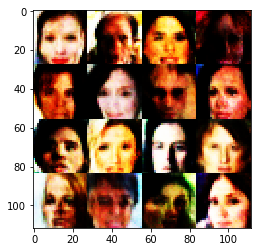

Epoch: 8/10	Step: 24520	 Discriminator Loss: 1.2081	 Generator Loss: 0.9436
Epoch: 8/10	Step: 24540	 Discriminator Loss: 1.3159	 Generator Loss: 1.1068
Epoch: 8/10	Step: 24560	 Discriminator Loss: 1.3650	 Generator Loss: 0.8102
Epoch: 8/10	Step: 24580	 Discriminator Loss: 0.9583	 Generator Loss: 1.5665
Epoch: 8/10	Step: 24600	 Discriminator Loss: 1.2603	 Generator Loss: 1.2083
Epoch: 8/10	Step: 24620	 Discriminator Loss: 1.4862	 Generator Loss: 0.4583
Epoch: 8/10	Step: 24640	 Discriminator Loss: 1.0604	 Generator Loss: 0.9521
Epoch: 8/10	Step: 24660	 Discriminator Loss: 1.2038	 Generator Loss: 0.7273
Epoch: 8/10	Step: 24680	 Discriminator Loss: 1.3402	 Generator Loss: 0.7905
Epoch: 8/10	Step: 24700	 Discriminator Loss: 1.4462	 Generator Loss: 0.9016
Epoch: 8/10	Step: 24720	 Discriminator Loss: 1.3286	 Generator Loss: 0.7917
Epoch: 8/10	Step: 24740	 Discriminator Loss: 1.7149	 Generator Loss: 1.4422
Epoch: 8/10	Step: 24760	 Discriminator Loss: 1.2046	 Generator Loss: 0.7358
Epoch: 8/10	

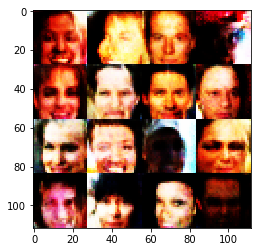

Epoch: 8/10	Step: 25020	 Discriminator Loss: 1.3479	 Generator Loss: 0.6415
Epoch: 8/10	Step: 25040	 Discriminator Loss: 1.0223	 Generator Loss: 2.0712
Epoch: 8/10	Step: 25060	 Discriminator Loss: 1.2228	 Generator Loss: 1.1369
Epoch: 8/10	Step: 25080	 Discriminator Loss: 1.2532	 Generator Loss: 0.9511
Epoch: 8/10	Step: 25100	 Discriminator Loss: 1.1720	 Generator Loss: 0.9406
Epoch: 8/10	Step: 25120	 Discriminator Loss: 1.3181	 Generator Loss: 0.6245
Epoch: 8/10	Step: 25140	 Discriminator Loss: 1.2829	 Generator Loss: 0.7872
Epoch: 8/10	Step: 25160	 Discriminator Loss: 1.3316	 Generator Loss: 0.7299
Epoch: 8/10	Step: 25180	 Discriminator Loss: 1.4944	 Generator Loss: 0.4612
Epoch: 8/10	Step: 25200	 Discriminator Loss: 1.2622	 Generator Loss: 0.7338
Epoch: 8/10	Step: 25220	 Discriminator Loss: 1.1189	 Generator Loss: 1.0315
Epoch: 8/10	Step: 25240	 Discriminator Loss: 1.3905	 Generator Loss: 0.7478
Epoch: 8/10	Step: 25260	 Discriminator Loss: 1.4405	 Generator Loss: 0.5110
Epoch: 8/10	

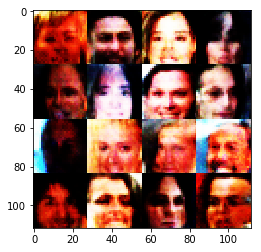

Epoch: 9/10	Step: 25520	 Discriminator Loss: 1.3083	 Generator Loss: 0.6768
Epoch: 9/10	Step: 25540	 Discriminator Loss: 1.3076	 Generator Loss: 0.7399
Epoch: 9/10	Step: 25560	 Discriminator Loss: 1.1364	 Generator Loss: 0.9375
Epoch: 9/10	Step: 25580	 Discriminator Loss: 1.7201	 Generator Loss: 0.3396
Epoch: 9/10	Step: 25600	 Discriminator Loss: 1.1433	 Generator Loss: 0.9238
Epoch: 9/10	Step: 25620	 Discriminator Loss: 1.0494	 Generator Loss: 0.8961
Epoch: 9/10	Step: 25640	 Discriminator Loss: 1.1756	 Generator Loss: 0.8784
Epoch: 9/10	Step: 25660	 Discriminator Loss: 1.4007	 Generator Loss: 0.5563
Epoch: 9/10	Step: 25680	 Discriminator Loss: 1.3241	 Generator Loss: 1.0629
Epoch: 9/10	Step: 25700	 Discriminator Loss: 1.3424	 Generator Loss: 0.7742
Epoch: 9/10	Step: 25720	 Discriminator Loss: 1.3861	 Generator Loss: 0.6422
Epoch: 9/10	Step: 25740	 Discriminator Loss: 1.7291	 Generator Loss: 1.6826
Epoch: 9/10	Step: 25760	 Discriminator Loss: 1.4159	 Generator Loss: 0.4992
Epoch: 9/10	

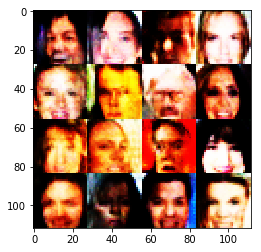

Epoch: 9/10	Step: 26020	 Discriminator Loss: 1.3689	 Generator Loss: 0.7258
Epoch: 9/10	Step: 26040	 Discriminator Loss: 1.2725	 Generator Loss: 1.2310
Epoch: 9/10	Step: 26060	 Discriminator Loss: 1.2018	 Generator Loss: 0.9637
Epoch: 9/10	Step: 26080	 Discriminator Loss: 1.3501	 Generator Loss: 0.9786
Epoch: 9/10	Step: 26100	 Discriminator Loss: 1.2982	 Generator Loss: 0.8672
Epoch: 9/10	Step: 26120	 Discriminator Loss: 0.9737	 Generator Loss: 1.0366
Epoch: 9/10	Step: 26140	 Discriminator Loss: 1.4470	 Generator Loss: 0.5417
Epoch: 9/10	Step: 26160	 Discriminator Loss: 1.0631	 Generator Loss: 1.0027
Epoch: 9/10	Step: 26180	 Discriminator Loss: 1.6038	 Generator Loss: 0.3980
Epoch: 9/10	Step: 26200	 Discriminator Loss: 1.3374	 Generator Loss: 0.9240
Epoch: 9/10	Step: 26220	 Discriminator Loss: 1.6276	 Generator Loss: 0.4393
Epoch: 9/10	Step: 26240	 Discriminator Loss: 1.4358	 Generator Loss: 0.5922
Epoch: 9/10	Step: 26260	 Discriminator Loss: 1.5127	 Generator Loss: 1.2823
Epoch: 9/10	

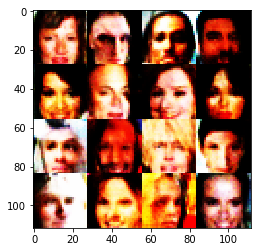

Epoch: 9/10	Step: 26520	 Discriminator Loss: 1.1694	 Generator Loss: 1.0710
Epoch: 9/10	Step: 26540	 Discriminator Loss: 1.3290	 Generator Loss: 0.6438
Epoch: 9/10	Step: 26560	 Discriminator Loss: 1.6164	 Generator Loss: 1.4451
Epoch: 9/10	Step: 26580	 Discriminator Loss: 1.0815	 Generator Loss: 1.0168
Epoch: 9/10	Step: 26600	 Discriminator Loss: 1.3315	 Generator Loss: 0.5564
Epoch: 9/10	Step: 26620	 Discriminator Loss: 1.0245	 Generator Loss: 1.3053
Epoch: 9/10	Step: 26640	 Discriminator Loss: 0.9638	 Generator Loss: 1.3052
Epoch: 9/10	Step: 26660	 Discriminator Loss: 1.3146	 Generator Loss: 0.7543
Epoch: 9/10	Step: 26680	 Discriminator Loss: 1.0037	 Generator Loss: 1.8883
Epoch: 9/10	Step: 26700	 Discriminator Loss: 0.7384	 Generator Loss: 1.5626
Epoch: 9/10	Step: 26720	 Discriminator Loss: 1.2821	 Generator Loss: 0.8968
Epoch: 9/10	Step: 26740	 Discriminator Loss: 1.3830	 Generator Loss: 0.6452
Epoch: 9/10	Step: 26760	 Discriminator Loss: 1.4079	 Generator Loss: 0.6169
Epoch: 9/10	

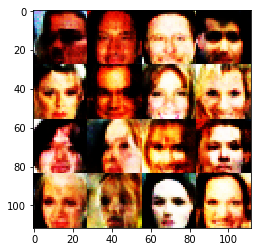

Epoch: 9/10	Step: 27020	 Discriminator Loss: 1.2743	 Generator Loss: 0.8648
Epoch: 9/10	Step: 27040	 Discriminator Loss: 1.3946	 Generator Loss: 0.8204
Epoch: 9/10	Step: 27060	 Discriminator Loss: 0.9643	 Generator Loss: 1.7932
Epoch: 9/10	Step: 27080	 Discriminator Loss: 1.3290	 Generator Loss: 0.6584
Epoch: 9/10	Step: 27100	 Discriminator Loss: 1.2924	 Generator Loss: 0.7903
Epoch: 9/10	Step: 27120	 Discriminator Loss: 1.2983	 Generator Loss: 0.6921
Epoch: 9/10	Step: 27140	 Discriminator Loss: 1.3304	 Generator Loss: 0.7356
Epoch: 9/10	Step: 27160	 Discriminator Loss: 0.8436	 Generator Loss: 1.1587
Epoch: 9/10	Step: 27180	 Discriminator Loss: 1.1362	 Generator Loss: 0.9799
Epoch: 9/10	Step: 27200	 Discriminator Loss: 1.4252	 Generator Loss: 0.8138
Epoch: 9/10	Step: 27220	 Discriminator Loss: 1.2975	 Generator Loss: 0.9041
Epoch: 9/10	Step: 27240	 Discriminator Loss: 1.3749	 Generator Loss: 0.7336
Epoch: 9/10	Step: 27260	 Discriminator Loss: 1.0156	 Generator Loss: 1.2254
Epoch: 9/10	

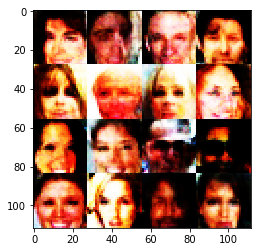

Epoch: 9/10	Step: 27520	 Discriminator Loss: 1.1736	 Generator Loss: 1.0493
Epoch: 9/10	Step: 27540	 Discriminator Loss: 0.9228	 Generator Loss: 1.4273
Epoch: 9/10	Step: 27560	 Discriminator Loss: 1.3447	 Generator Loss: 0.7272
Epoch: 9/10	Step: 27580	 Discriminator Loss: 1.4529	 Generator Loss: 0.4674
Epoch: 9/10	Step: 27600	 Discriminator Loss: 1.6884	 Generator Loss: 0.3499
Epoch: 9/10	Step: 27620	 Discriminator Loss: 1.1550	 Generator Loss: 0.9429
Epoch: 9/10	Step: 27640	 Discriminator Loss: 1.2153	 Generator Loss: 0.7756
Epoch: 9/10	Step: 27660	 Discriminator Loss: 1.1285	 Generator Loss: 0.7878
Epoch: 9/10	Step: 27680	 Discriminator Loss: 1.2862	 Generator Loss: 0.7359
Epoch: 9/10	Step: 27700	 Discriminator Loss: 1.2346	 Generator Loss: 0.9345
Epoch: 9/10	Step: 27720	 Discriminator Loss: 0.9324	 Generator Loss: 1.3089
Epoch: 9/10	Step: 27740	 Discriminator Loss: 1.3742	 Generator Loss: 1.2047
Epoch: 9/10	Step: 27760	 Discriminator Loss: 1.1817	 Generator Loss: 0.9160
Epoch: 9/10	

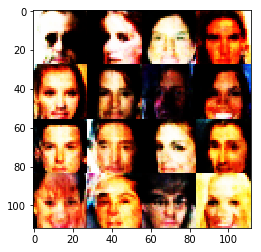

Epoch: 9/10	Step: 28020	 Discriminator Loss: 0.9608	 Generator Loss: 1.4762
Epoch: 9/10	Step: 28040	 Discriminator Loss: 1.3921	 Generator Loss: 0.6063
Epoch: 9/10	Step: 28060	 Discriminator Loss: 1.3426	 Generator Loss: 0.6226
Epoch: 9/10	Step: 28080	 Discriminator Loss: 1.5368	 Generator Loss: 0.3982
Epoch: 9/10	Step: 28100	 Discriminator Loss: 1.2617	 Generator Loss: 0.6627
Epoch: 9/10	Step: 28120	 Discriminator Loss: 1.2058	 Generator Loss: 0.7123
Epoch: 9/10	Step: 28140	 Discriminator Loss: 1.3415	 Generator Loss: 0.7558
Epoch: 9/10	Step: 28160	 Discriminator Loss: 1.2830	 Generator Loss: 0.7827
Epoch: 9/10	Step: 28180	 Discriminator Loss: 1.2079	 Generator Loss: 1.0390
Epoch: 9/10	Step: 28200	 Discriminator Loss: 1.0856	 Generator Loss: 1.1505
Epoch: 9/10	Step: 28220	 Discriminator Loss: 1.2822	 Generator Loss: 0.7198
Epoch: 9/10	Step: 28240	 Discriminator Loss: 1.4045	 Generator Loss: 0.6677
Epoch: 9/10	Step: 28260	 Discriminator Loss: 1.0355	 Generator Loss: 0.9351
Epoch: 9/10	

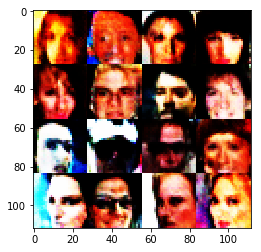

Epoch: 10/10	Step: 28520	 Discriminator Loss: 1.2211	 Generator Loss: 0.7867
Epoch: 10/10	Step: 28540	 Discriminator Loss: 1.2345	 Generator Loss: 0.8321
Epoch: 10/10	Step: 28560	 Discriminator Loss: 1.4457	 Generator Loss: 0.5285
Epoch: 10/10	Step: 28580	 Discriminator Loss: 1.2811	 Generator Loss: 0.8027
Epoch: 10/10	Step: 28600	 Discriminator Loss: 1.1292	 Generator Loss: 1.1038
Epoch: 10/10	Step: 28620	 Discriminator Loss: 1.6238	 Generator Loss: 0.4167
Epoch: 10/10	Step: 28640	 Discriminator Loss: 1.4504	 Generator Loss: 0.5643
Epoch: 10/10	Step: 28660	 Discriminator Loss: 1.5634	 Generator Loss: 0.4417
Epoch: 10/10	Step: 28680	 Discriminator Loss: 1.1675	 Generator Loss: 1.0560
Epoch: 10/10	Step: 28700	 Discriminator Loss: 1.2284	 Generator Loss: 0.6921
Epoch: 10/10	Step: 28720	 Discriminator Loss: 1.2119	 Generator Loss: 0.8152
Epoch: 10/10	Step: 28740	 Discriminator Loss: 1.2251	 Generator Loss: 0.9612
Epoch: 10/10	Step: 28760	 Discriminator Loss: 1.2506	 Generator Loss: 1.3572

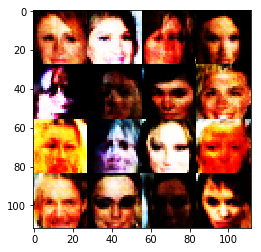

Epoch: 10/10	Step: 29020	 Discriminator Loss: 1.3314	 Generator Loss: 0.7041
Epoch: 10/10	Step: 29040	 Discriminator Loss: 1.2361	 Generator Loss: 0.8482
Epoch: 10/10	Step: 29060	 Discriminator Loss: 1.3032	 Generator Loss: 0.9045
Epoch: 10/10	Step: 29080	 Discriminator Loss: 1.3341	 Generator Loss: 1.0879
Epoch: 10/10	Step: 29100	 Discriminator Loss: 0.8716	 Generator Loss: 2.2741
Epoch: 10/10	Step: 29120	 Discriminator Loss: 1.2606	 Generator Loss: 1.0105
Epoch: 10/10	Step: 29140	 Discriminator Loss: 1.1591	 Generator Loss: 0.8048
Epoch: 10/10	Step: 29160	 Discriminator Loss: 1.2319	 Generator Loss: 0.8966
Epoch: 10/10	Step: 29180	 Discriminator Loss: 1.1696	 Generator Loss: 1.7316
Epoch: 10/10	Step: 29200	 Discriminator Loss: 1.3425	 Generator Loss: 0.6328
Epoch: 10/10	Step: 29220	 Discriminator Loss: 1.5275	 Generator Loss: 0.4641
Epoch: 10/10	Step: 29240	 Discriminator Loss: 1.2465	 Generator Loss: 1.5134
Epoch: 10/10	Step: 29260	 Discriminator Loss: 1.2402	 Generator Loss: 1.1821

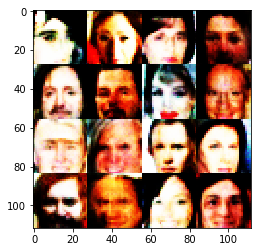

Epoch: 10/10	Step: 29520	 Discriminator Loss: 1.3589	 Generator Loss: 0.6437
Epoch: 10/10	Step: 29540	 Discriminator Loss: 0.9544	 Generator Loss: 1.3920
Epoch: 10/10	Step: 29560	 Discriminator Loss: 1.2713	 Generator Loss: 0.7860
Epoch: 10/10	Step: 29580	 Discriminator Loss: 1.5426	 Generator Loss: 0.9240
Epoch: 10/10	Step: 29600	 Discriminator Loss: 1.2826	 Generator Loss: 0.9157
Epoch: 10/10	Step: 29620	 Discriminator Loss: 1.1851	 Generator Loss: 0.7897
Epoch: 10/10	Step: 29640	 Discriminator Loss: 1.5061	 Generator Loss: 0.5696
Epoch: 10/10	Step: 29660	 Discriminator Loss: 1.2075	 Generator Loss: 1.0244
Epoch: 10/10	Step: 29680	 Discriminator Loss: 1.1516	 Generator Loss: 0.7978
Epoch: 10/10	Step: 29700	 Discriminator Loss: 1.1977	 Generator Loss: 0.7973
Epoch: 10/10	Step: 29720	 Discriminator Loss: 1.1403	 Generator Loss: 0.8259
Epoch: 10/10	Step: 29740	 Discriminator Loss: 1.0129	 Generator Loss: 1.0508
Epoch: 10/10	Step: 29760	 Discriminator Loss: 1.2077	 Generator Loss: 1.0994

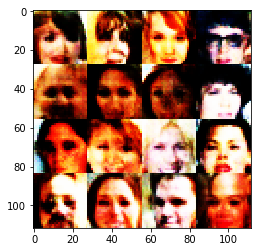

Epoch: 10/10	Step: 30020	 Discriminator Loss: 1.3425	 Generator Loss: 0.7056
Epoch: 10/10	Step: 30040	 Discriminator Loss: 1.3805	 Generator Loss: 0.5175
Epoch: 10/10	Step: 30060	 Discriminator Loss: 1.2831	 Generator Loss: 0.6660
Epoch: 10/10	Step: 30080	 Discriminator Loss: 1.1909	 Generator Loss: 0.7616
Epoch: 10/10	Step: 30100	 Discriminator Loss: 1.2153	 Generator Loss: 1.0683
Epoch: 10/10	Step: 30120	 Discriminator Loss: 1.3677	 Generator Loss: 1.2015
Epoch: 10/10	Step: 30140	 Discriminator Loss: 1.3646	 Generator Loss: 0.5313
Epoch: 10/10	Step: 30160	 Discriminator Loss: 1.0120	 Generator Loss: 1.5307
Epoch: 10/10	Step: 30180	 Discriminator Loss: 1.1793	 Generator Loss: 0.8330
Epoch: 10/10	Step: 30200	 Discriminator Loss: 1.4995	 Generator Loss: 0.4642
Epoch: 10/10	Step: 30220	 Discriminator Loss: 1.3945	 Generator Loss: 0.7414
Epoch: 10/10	Step: 30240	 Discriminator Loss: 1.2160	 Generator Loss: 0.9698
Epoch: 10/10	Step: 30260	 Discriminator Loss: 1.2908	 Generator Loss: 0.6713

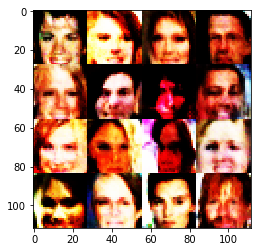

Epoch: 10/10	Step: 30520	 Discriminator Loss: 1.3241	 Generator Loss: 0.7400
Epoch: 10/10	Step: 30540	 Discriminator Loss: 1.3141	 Generator Loss: 0.6283
Epoch: 10/10	Step: 30560	 Discriminator Loss: 1.9491	 Generator Loss: 1.6830
Epoch: 10/10	Step: 30580	 Discriminator Loss: 1.3625	 Generator Loss: 1.2423
Epoch: 10/10	Step: 30600	 Discriminator Loss: 1.4057	 Generator Loss: 1.3030
Epoch: 10/10	Step: 30620	 Discriminator Loss: 1.3339	 Generator Loss: 0.7586
Epoch: 10/10	Step: 30640	 Discriminator Loss: 0.7754	 Generator Loss: 1.4209
Epoch: 10/10	Step: 30660	 Discriminator Loss: 1.1049	 Generator Loss: 0.9573
Epoch: 10/10	Step: 30680	 Discriminator Loss: 1.3191	 Generator Loss: 0.6618
Epoch: 10/10	Step: 30700	 Discriminator Loss: 1.3625	 Generator Loss: 0.5651
Epoch: 10/10	Step: 30720	 Discriminator Loss: 1.0808	 Generator Loss: 1.0792
Epoch: 10/10	Step: 30740	 Discriminator Loss: 1.1562	 Generator Loss: 0.8077
Epoch: 10/10	Step: 30760	 Discriminator Loss: 1.2948	 Generator Loss: 0.9186

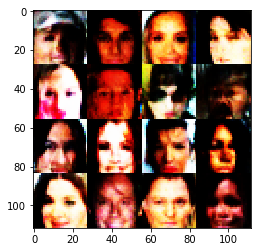

Epoch: 10/10	Step: 31020	 Discriminator Loss: 1.3227	 Generator Loss: 0.7708
Epoch: 10/10	Step: 31040	 Discriminator Loss: 1.3946	 Generator Loss: 1.1191
Epoch: 10/10	Step: 31060	 Discriminator Loss: 1.1851	 Generator Loss: 0.8624
Epoch: 10/10	Step: 31080	 Discriminator Loss: 1.2754	 Generator Loss: 0.8378
Epoch: 10/10	Step: 31100	 Discriminator Loss: 1.2374	 Generator Loss: 0.8530
Epoch: 10/10	Step: 31120	 Discriminator Loss: 1.2735	 Generator Loss: 0.7317
Epoch: 10/10	Step: 31140	 Discriminator Loss: 1.3346	 Generator Loss: 0.8621
Epoch: 10/10	Step: 31160	 Discriminator Loss: 1.2212	 Generator Loss: 0.9135
Epoch: 10/10	Step: 31180	 Discriminator Loss: 1.2765	 Generator Loss: 0.8985
Epoch: 10/10	Step: 31200	 Discriminator Loss: 0.9621	 Generator Loss: 1.5024
Epoch: 10/10	Step: 31220	 Discriminator Loss: 0.9652	 Generator Loss: 1.6484
Epoch: 10/10	Step: 31240	 Discriminator Loss: 1.1104	 Generator Loss: 1.6685
Epoch: 10/10	Step: 31260	 Discriminator Loss: 1.2620	 Generator Loss: 0.6048

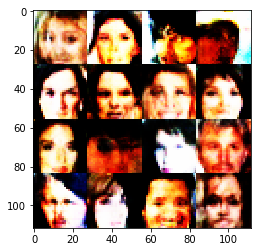

Epoch: 10/10	Step: 31520	 Discriminator Loss: 1.1045	 Generator Loss: 1.0788
Epoch: 10/10	Step: 31540	 Discriminator Loss: 1.1969	 Generator Loss: 0.6855
Epoch: 10/10	Step: 31560	 Discriminator Loss: 1.1655	 Generator Loss: 1.0249
Epoch: 10/10	Step: 31580	 Discriminator Loss: 1.2516	 Generator Loss: 0.7105
Epoch: 10/10	Step: 31600	 Discriminator Loss: 1.3532	 Generator Loss: 0.9274
Epoch: 10/10	Step: 31620	 Discriminator Loss: 1.4020	 Generator Loss: 0.7447
Epoch: 10/10	Step: 31640	 Discriminator Loss: 1.1247	 Generator Loss: 0.8946


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1
alpha = 0.1
smooth = 0.1
keep_prob = 0.8

print_every = 20
show_every = 500


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          print_every=print_every, show_every=show_every, alpha=alpha, smooth=smooth, keep_prob=keep_prob) # Some params added

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.